# <font color= 'blue'> Deep Learning
# <font color='blue'> Project 1 </font>

## <font color= 'blue'> Fully Connected Neural Network
Mehek Niwas || MTH 4320 Fall 2023

# <font color= 'blue'> Goals
*The goals of the project:*

1) Use a fully-connected feed forward neural network to predict the survival status of patients given a bone marrow transplant.

2) Calculation entropy for each layer of neural network

# <font color= 'blue'> Bone Marrow Transplants in Children Dataset
This dataset was obtained from from UCI Machine Learning Repository. Link: https://archive.ics.uci.edu/dataset/565/bone+marrow+transplant+children

#### **Input: Features**
Original Shape: 187 x 36

Dataset has data on 187 bone transplant patients, with 36 features on information such as DonorABO, Recipientage, PLTrecovery, etc. There are multiple binary, categorical, and integer features. Some patient entries contain missing values.  This is a small dataset, so K-fold cross validation was necessary for meaningful performance metrics

Data needed to be converted into 1-hot encoding and patient entries with missing values needed to be removed. Additionally, some features were found to contain redundant, inconsistent, and information, so those features were removed. One of the features was also found to be providing information directly related with the target value, so it was also removed to avoid falsified predictions. More specifics are in the preprocressing section.

#### **Output: Survival**
Original Shape: 187 x 1

Each patient entry is labeled with a binary classification of 0 or 1, indicating the survival status of the patient (dead or alive).

# PROJECT GOAL 1: <font color= 'blue'> Dataset, Cross Validation, & Model Setup
[Run this entire section to get trainX, trainY, testX, testY]

## Imports

In [ ]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import itertools

# model imports
from tensorflow import keras
from keras import layers, regularizers
import scipy.io as sio
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.regularizers import l1_l2

# pip installs (for data)
!pip install ucimlrepo

# k fold cross validation imports
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from typing import Tuple
import copy as cp
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## <font color= 'blue'> Dataset Preparation & Preprocessing Code
***Modifications:***
The total number of patients with all data was 142, so the data from 45 patients had to be removed for a balanced dataset.
- switched "disease" categorial column to 1-hot encoding
- removed "ALL" diseases and "diseasegroup" column due to redundancy
- removed "recipientage10" & "recipientageint" column due to redundancy with "recipientage" integer column
- removed "donorage35" column due to redundancy with "donorage" column
- removed "time to development of agvhd stage iii and iv" due to redundancy with "prescence of agvhd" column. values for time to development of agvhd were very skewed with the values to represent no development (ex: 1,000,000 days) as well
- removed "survival time" integer column due to conflict with output for prediciting patient survival status (ex: could possibly take age and survival time to figure out the status)

***Data Splits:***
Cross validation will be used on the training data split, and testing split will remain separate to evaluate the model at the end of the project.



In [ ]:
from ucimlrepo import fetch_ucirepo
bone_marrow_transplant_children = fetch_ucirepo(id=565)
print(bone_marrow_transplant_children.metadata)
print(bone_marrow_transplant_children.variables)

{'uci_id': 565, 'name': 'Bone marrow transplant: children', 'repository_url': 'https://archive.ics.uci.edu/dataset/565/bone+marrow+transplant+children', 'data_url': 'https://archive.ics.uci.edu/static/public/565/data.csv', 'abstract': 'The data set describes pediatric patients with several hematologic diseases, who were subject to the unmanipulated allogeneic unrelated donor hematopoietic stem cell transplantation.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 187, 'num_features': 36, 'feature_types': ['Integer', 'Real'], 'demographics': ['Gender', 'Age'], 'target_col': ['survival_status'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5NP6Z', 'creators': ['Marek Sikora', 'Łukasz Wróbel', 'Adam Gudyś'], 'intro_paper': {'title': 'GuideR: a guided separate-and-conquer rule learn

In [ ]:
# data (as pandas dataframes)
X = bone_marrow_transplant_children.data.features
Y = bone_marrow_transplant_children.data.targets
print("Original Dataset: ")
print("Shape of Inputs: X =", X.shape)
print("Shape of Outputs: Y =", Y.shape)
print("")

# Convert the column name to lowercase to ensure case insensitivity
X.columns = X.columns.str.lower()

# code for dropping rows with any missing values
original_index = X.index

# Dropping rows with missing values from the input DataFrame
cleaned_X = X.dropna()

# Filtering corresponding rows from the output DataFrame
cleaned_Y = Y.loc[original_index.isin(cleaned_X.index)]
cleaned_X.reset_index(drop=True, inplace = True) # resetting weird indexes

# code for dropping identified columns upon data inspection
d_columns = ['survival_time', 'time_to_agvhd_iii_iv', 'recipientage10', 'recipientageint', 'donorage35', 'diseasegroup']
cleaned_X = cleaned_X.drop(columns=d_columns, axis = 1)

cleaned_Y.reset_index(drop=True, inplace = True) # resetting weird indexes
print("Redudant and conflicting features: ")
for i in range(len(d_columns)):
  print("-- ", d_columns[i])
print("")

print("After removal of redundant and conflicting features, and patients with missing data: ")
print("New Shape of Inputs: X =", cleaned_X.shape)
print("New Shape of Outputs: Y =", cleaned_Y.shape)
print("")

# One hot encoding for disease categorical data
one_hot = pd.get_dummies(cleaned_X['disease']) # i think the drop_first = True didnt work!!
cleaned_X = cleaned_X.join(one_hot)
  # code for ALL in disease category
condition = cleaned_X['disease'].isin(['ALL'])  # condition
  # Modify values in specified columns based on the condition
cleaned_X.loc[condition, ['AML', 'chronic', 'lymphoma', 'nonmalignant']] = 1
cleaned_X = cleaned_X.drop('disease', axis=1)
cleaned_X = cleaned_X.drop('ALL', axis=1)

# making sure all columns are float type data!!
cleaned_X = cleaned_X.astype('float64')
cleaned_Y = cleaned_Y.astype('float64')

print("After switch to 1-hot encoding for disease feature")
print("New Shape of Inputs: X =", cleaned_X.shape)
print("New Shape of Outputs: Y =", cleaned_Y.shape)
print("")

Original Dataset: 
Shape of Inputs: X = (187, 36)
Shape of Outputs: Y = (187, 1)

Redudant and conflicting features: 
--  survival_time
--  time_to_agvhd_iii_iv
--  recipientage10
--  recipientageint
--  donorage35
--  diseasegroup

After removal of redundant and conflicting features, and patients with missing data: 
New Shape of Inputs: X = (142, 30)
New Shape of Outputs: Y = (142, 1)

After switch to 1-hot encoding for disease feature
New Shape of Inputs: X = (142, 33)
New Shape of Outputs: Y = (142, 1)



In [ ]:
# Ensuring all data types are float
cleaned_X = cleaned_X.astype('float')
cleaned_Y = cleaned_Y.astype('float')

# Display the modified DataFrame
print("Modified Inputs: ")
# Save the dataframe to a CSV file
cleaned_X.to_csv('view_full_features.csv')
cleaned_Y.to_csv('full_targets.csv')
cleaned_X

Modified Inputs: 


,recipientgender,stemcellsource,donorage,iiiv,gendermatch,donorabo,recipientabo,recipientrh,abomatch,cmvstatus,...,cd34kgx10d6,cd3dcd34,cd3dkgx10d8,rbodymass,ancrecovery,pltrecovery,AML,chronic,lymphoma,nonmalignant
0,1.0,1.0,22.830137,1.0,0.0,1.0,1.0,1.0,0.0,3.0,...,7.20,1.338760,5.38,35.0,19.0,51.0,1.0,1.0,1.0,1.0
1,1.0,0.0,23.342466,1.0,0.0,-1.0,-1.0,1.0,0.0,0.0,...,4.50,11.078295,0.41,20.6,16.0,37.0,1.0,1.0,1.0,1.0
2,1.0,0.0,26.394521,1.0,0.0,-1.0,-1.0,1.0,0.0,2.0,...,7.94,19.013230,0.42,23.4,23.0,20.0,1.0,1.0,1.0,1.0
3,0.0,1.0,33.358904,0.0,0.0,1.0,2.0,0.0,1.0,0.0,...,51.85,3.972255,13.05,9.0,14.0,14.0,0.0,1.0,0.0,0.0
4,1.0,1.0,32.641096,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,23.54,3.772555,6.24,20.5,15.0,14.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1.0,0.0,30.024658,1.0,1.0,1.0,2.0,0.0,1.0,0.0,...,8.11,16.326160,0.50,28.0,16.0,100.0,1.0,1.0,1.0,1.0
138,1.0,1.0,37.575342,1.0,0.0,1.0,1.0,0.0,0.0,3.0,...,11.08,2.522750,4.39,44.0,15.0,22.0,0.0,0.0,1.0,0.0
139,0.0,1.0,22.895890,0.0,0.0,1.0,0.0,1.0,1.0,2.0,...,4.64,1.038858,4.47,44.5,12.0,30.0,1.0,0.0,0.0,0.0
140,0.0,1.0,27.347945,1.0,0.0,1.0,-1.0,1.0,1.0,3.0,...,7.73,1.635559,4.73,33.0,16.0,16.0,0.0,0.0,0.0,1.0


In [ ]:
# Convert DataFrames to numpy array without column names --> prep for computations
X_array = cleaned_X.values; print(X_array.shape)
Y_array = cleaned_Y.values; print(Y_array.shape)
# print(X_array, " ", X_array.shape); print(); print(Y_array, " ", Y_array.shape) # check arrays

(142, 33)
(142, 1)


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

# split the data into training and test sets (randomized)
trainX, testX, trainY, testY = train_test_split(X_array, Y_array, test_size = 0.40, random_state = 42)

print("trainInputs shape: ", trainX.shape); print("trainOutputs shape: ", trainY.shape)
print("testInputs shape: ", testX.shape); print("testInputs shape: ", testY.shape)

trainInputs shape:  (85, 33)
trainOutputs shape:  (85, 1)
testInputs shape:  (57, 33)
testInputs shape:  (57, 1)


## <font color= 'blue'> Cross Validation Code
ended up removing training over epochs because it wasn't as helpful with so many folds

In [ ]:
# have to define create_model function before executing this
# have to re define create_model function before every execution

def evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs):
  k_fold = KFold(num_folds, shuffle=True, random_state=1)
  num_fold = 1

  predicted_targets = np.array([])
  t_predicted_targets = np.array([])

  actual_targets = np.array([])
  t_actual_targets = np.array([])

  accuracy_list = list()
  t_accuracy_list = list()

  cm_list = []
  t_cm_list = []

  for train_ix, val_ix in k_fold.split(trainX):
    print("")
    print("Training for Fold #", num_fold)

    # using indicies to create datasets specific to current fold
    train_foldX, train_foldY, val_foldX, val_foldY  = trainX[train_ix], trainY[train_ix], trainX[val_ix], trainY[val_ix]

    # Fit the classifier
    model = create_model()

    H = model.fit(train_foldX, train_foldY, batch_size=u_batch_size,
                     epochs=max_epochs,
                     verbose=1)

    # Predict the labels of the training set samples
    threshold = 0.5

    t_predicted_labels = model.predict(train_foldX)
    for i in range(len(t_predicted_labels)):
      if (t_predicted_labels[i]>=threshold) == True:
        t_predicted_labels[i] = 1
      else:
        t_predicted_labels[i] = 0


    # Predict the labels of the valid set samples
    predicted_labels = model.predict(val_foldX) # in keras, each prediction is a list of probabilities for each class
    # making each prediction only 1 value, not a list of probabilities for each class. sklearn expects 1 value.
     # if multiple classes, have to do argmax!!
    print("keras classifications: ", predicted_labels)
    for i in range(len(predicted_labels)):
      if (predicted_labels[i]>=threshold) == True:
        predicted_labels[i] = 1
      else:
        predicted_labels[i] = 0
    print("interpreted classifications: ", predicted_labels)

    # do confusion matrix magic stuff
      # training
    t_cm = confusion_matrix(train_foldY, t_predicted_labels)
    t_cm_list.append(t_cm)

      # valid
    cm = confusion_matrix(val_foldY, predicted_labels)
    cm_list.append(cm)

    # update accuracies + pred targets + actual targets
    t_accuracy = accuracy_score(train_foldY, t_predicted_labels)
    accuracy = accuracy_score(val_foldY, predicted_labels)

    t_predicted_targets = np.append(t_predicted_targets, t_predicted_labels)
    predicted_targets = np.append(predicted_targets, predicted_labels)

    t_actual_targets = np.append(t_actual_targets, train_foldY)
    actual_targets = np.append(actual_targets, val_foldY)

    t_accuracy_list.append(t_accuracy)
    accuracy_list.append(accuracy)
    num_fold = num_fold + 1

  return model, t_predicted_targets, predicted_targets, t_actual_targets, actual_targets, t_accuracy_list, accuracy_list, t_cm_list, cm_list

  # example usage:
  # t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)
  # MODEL IS CREATED **INSIDE** THE FUNCTION FOR EACH FOLD!! def create_model() function MUST be made prior to running

In [ ]:
# have to define create_model function before executing this
# have to re define create_model function before every execution

def balanced_evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs):
  k_fold = KFold(num_folds, shuffle=True, random_state=1)
  num_fold = 1

  predicted_targets = np.array([])
  t_predicted_targets = np.array([])

  actual_targets = np.array([])
  t_actual_targets = np.array([])

  accuracy_list = list()
  t_accuracy_list = list()

  cm_list = []
  t_cm_list = []

  for train_ix, val_ix in k_fold.split(trainX):
    print("")
    print("Training for Fold #", num_fold)

    # using indicies to create datasets specific to current fold
    train_foldX, train_foldY, val_foldX, val_foldY  = trainX[train_ix], trainY[train_ix], trainX[val_ix], trainY[val_ix]

    # set up weights for balancing
    counts = np.bincount(train_foldY[:, 0].astype(int))

    print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_foldY)
    )
    )

    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = (1.0 / counts[1])
    class_weight = {0: weight_for_0, 1: weight_for_1}

    # Fit the classifier
    model = create_model()
    H = model.fit(train_foldX, train_foldY, batch_size=u_batch_size,
                     epochs=max_epochs,
                     verbose=1, class_weight=class_weight)

    # Predict the labels of the training set samples
    threshold = 0.5

    t_predicted_labels = model.predict(train_foldX)
    for i in range(len(t_predicted_labels)):
      if (t_predicted_labels[i]>=threshold) == True:
        t_predicted_labels[i] = 1
      else:
        t_predicted_labels[i] = 0


    # Predict the labels of the valid set samples
    predicted_labels = model.predict(val_foldX) # in keras, each prediction is a list of probabilities for each class
    # making each prediction only 1 value, not a list of probabilities for each class. sklearn expects 1 value.
     # if multiple classes, have to do argmax!!
    print("keras classifications: ", predicted_labels)
    for i in range(len(predicted_labels)):
      if (predicted_labels[i]>=threshold) == True:
        predicted_labels[i] = 1
      else:
        predicted_labels[i] = 0
    print("interpreted classifications: ", predicted_labels)

    # do confusion matrix magic stuff
      # training
    t_cm = confusion_matrix(train_foldY, t_predicted_labels)
    t_cm_list.append(t_cm)

      # valid
    cm = confusion_matrix(val_foldY, predicted_labels)
    cm_list.append(cm)

    # update accuracies + pred targets + actual targets
    t_accuracy = accuracy_score(train_foldY, t_predicted_labels)
    accuracy = accuracy_score(val_foldY, predicted_labels)

    t_predicted_targets = np.append(t_predicted_targets, t_predicted_labels)
    predicted_targets = np.append(predicted_targets, predicted_labels)

    t_actual_targets = np.append(t_actual_targets, train_foldY)
    actual_targets = np.append(actual_targets, val_foldY)

    t_accuracy_list.append(t_accuracy)
    accuracy_list.append(accuracy)
    num_fold = num_fold + 1

  return t_predicted_targets, predicted_targets, t_actual_targets, actual_targets, t_accuracy_list, accuracy_list, t_cm_list, cm_list

  # example usage:
  # t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)
  # MODEL IS CREATED **INSIDE** THE FUNCTION FOR EACH FOLD!! def create_model() function MUST be made prior to running

## <font color= 'blue'> Performance Metrics Code
***Calculations:***
- average accuracies, precision, recall, and confusion matrix (average meaning average of all folds) [ < total predictions]
- complied confusion from the total of all predictions (complies all folds) [= total predictions]
- total predictions from all folds
- instances of each class in a list of target labels

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
def plot_confusion_matrix(predicted_labels_list, y_test_list):

  # Calculate the confusion matrix using the accumulated true labels and predictions
  cm = confusion_matrix(y_test_list, predicted_labels_list)

  # Visualize the confusion matrix + Set Title!!
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Success", "Failure"]) # display labels are set from 0 to n-1
  disp.plot()
  #plt.grid(None) # have to call this because otherwise a weird grid shows up
  disp.ax_.set_title("Compiled Confusion Matrix")

In [ ]:
# string is validation or training
def print_metrics(u_str, preds, trues, acc_list, cm_list):

  print(u_str, " Metrics from Cross Validation")
  print("")
  print("Total Predictions: ", preds.shape[0])
  print("")
  plot_confusion_matrix(preds, trues)
  print("")

  print("Mean (exact) accuracy:", np.mean(acc_list))
  print("Standard deviation of accuracy:", np.std(acc_list))
  mean_cm = np.mean(cm_list, axis=0)


  # REMEMBER CONFUSION MATRIX SYNTAX IS (TRUE VALUE, PREDICTED VALUE)
  print("Average", u_str.lower(), "confusion matrix: ")
  print("", {'tn': mean_cm[0, 0],'fp': mean_cm[0, 1]})
  print("", {'fn': mean_cm[1, 0],'tp': mean_cm[1, 1]})
  print("Average", u_str.lower(), "accuracy: ", (mean_cm[0,0] + mean_cm[1,1])/(mean_cm[0,0] + mean_cm[1,1] + mean_cm[0,1] + mean_cm[1,0]))
  print("Average", u_str.lower(), "precision: ", (mean_cm[1,1])/(mean_cm[1,1] + mean_cm[0,1]))
  print("Average", u_str.lower(), "recall: ", (mean_cm[1,1])/(mean_cm[1,1] + mean_cm[1,0]))
  print("")

  print("Classification Report for Complied", u_str, " Metrics")
  print(classification_report(trues, preds, labels=[0, 1]))

  # example usage:
  # print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)
  # print_metrics("Training", v_preds, v_trues, v_acc_list, v_cm_list)

In [ ]:
def instances_in_set(y_vals):
  success_counts = 0
  failure_counts = 0

  for i in range(len(y_vals)):
    if (t_trues[i] == 0):
      success_counts = success_counts + 1
    else:
      failure_counts = failure_counts + 1

  print("Number of true successes: ", success_counts)
  print("Number of true failures: ", failure_counts)

# <font color= 'purple'> Benchmark Model
Input layer and sigmoid-activated output layer. Goes from 33 features to 1 --> like a logistic regression model with cross entropy loss
binary output.

**K-folds = 4**
**Epochs = 10**

*Architecture:*
- layers = 1; dropout = 0.0; batches = 1; activation = sigmoid

*Results:* Validation average accuracy is 53%. High overfitting (estimated 10%)




In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 3ms/step - loss: 2.3389 - accuracy: 0.5238
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 1.9908 - accuracy: 0.6032
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 1.7916 - accuracy: 0.6190
Epoch 4/10
63/63 [==============================] - 0s 6ms/step - loss: 1.5923 - accuracy: 0.6349
Epoch 5/10
63/63 [==============================] - 0s 5ms/step - loss: 1.4166 - accuracy: 0.6508
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 1.2501 - accuracy: 0.6667
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 1.0940 - accuracy: 0.6508
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9678 - accuracy: 0.6667
Epoch 9/10
63/63 [==============================] - 0s 5ms/step - loss: 0.8521 - accuracy: 0.6349
Epoch 10/10
1/1 [==============================] - 0s 89ms/step
keras classifications:  [[9.240

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6315724206349207
Standard deviation of accuracy: 0.07767580376918885
Average training confusion matrix: 
 {'tn': 31.0, 'fp': 10.25}
 {'fn': 13.25, 'tp': 9.25}
Average training accuracy:  0.6313725490196078
Average training precision:  0.47435897435897434
Average training recall:  0.4111111111111111

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       165
           1       0.47      0.41      0.44        90

    accuracy                           0.63       255
   macro avg       0.59      0.58      0.58       255
weighted avg       0.62      0.63      0.62       255



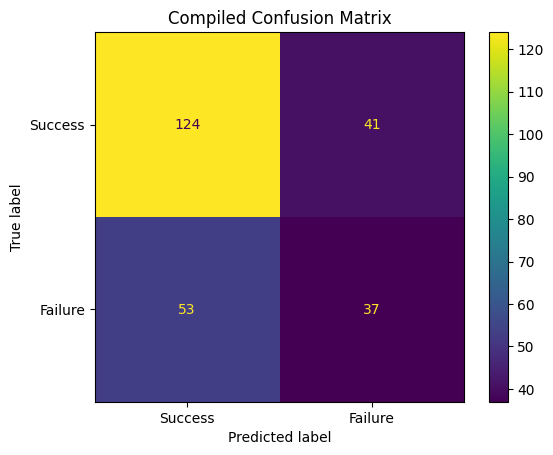

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.525974025974026
Standard deviation of accuracy: 0.2078485673928515
Average validation confusion matrix: 
 {'tn': 9.25, 'fp': 4.5}
 {'fn': 5.5, 'tp': 2.0}
Average validation accuracy:  0.5294117647058824
Average validation precision:  0.3076923076923077
Average validation recall:  0.26666666666666666

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        55
           1       0.31      0.27      0.29        30

    accuracy                           0.53        85
   macro avg       0.47      0.47      0.47        85
weighted avg       0.51      0.53      0.52        85



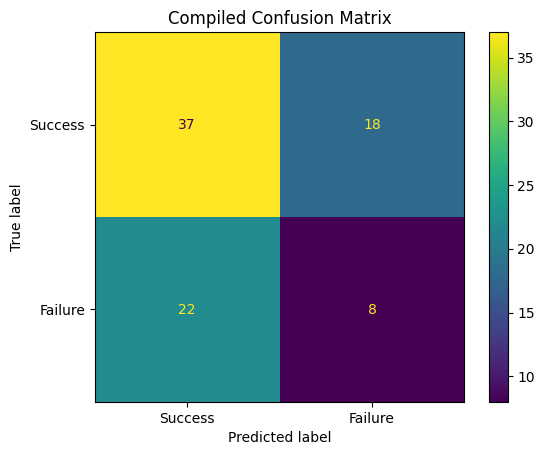

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> Experiment 1: Number of Layers (1, 2, 3)
Half of neurons from previous layer in each additional layer.

Best model = 2 Layers

## 2 Layers
1 hidden layer

Training average accuracy: 70%

Validation average accuracy: 62%

Estimated overfitting: 8%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'sigmoid'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 2s 6ms/step - loss: 0.7686 - accuracy: 0.3810
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.4762
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6032
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6667
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6825
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 0.6262 - accuracy: 0.6825
Epoch 7/10
63/63 [==============================] - 1s 15ms/step - loss: 0.6188 - accuracy: 0.6825
Epoch 8/10
63/63 [==============================] - 0s 5ms/step - loss: 0.6161 - accuracy: 0.6508
Epoch 9/10
63/63 [==============================] - 0s 7ms/step - loss: 0.6092 - accuracy: 0.6825
Epoch 10/10
1/1 [==============================] - 0s 43ms/step
keras classifications:  [[0.38

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6901041666666666
Standard deviation of accuracy: 0.03636520844731495
Average training confusion matrix: 
 {'tn': 40.75, 'fp': 0.5}
 {'fn': 19.25, 'tp': 3.25}
Average training accuracy:  0.6901960784313725
Average training precision:  0.8666666666666667
Average training recall:  0.14444444444444443

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.68      0.99      0.80       165
           1       0.87      0.14      0.25        90

    accuracy                           0.69       255
   macro avg       0.77      0.57      0.53       255
weighted avg       0.75      0.69      0.61       255



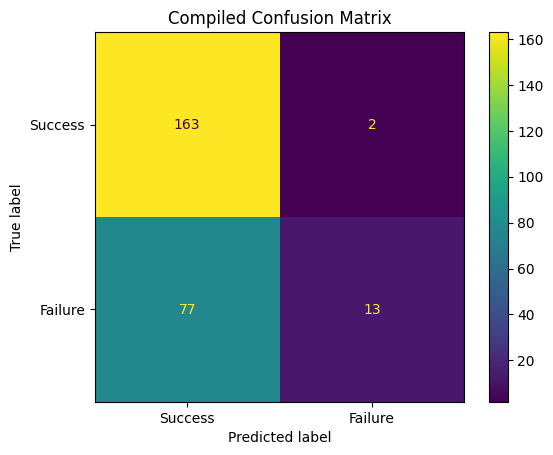

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.6341991341991342
Standard deviation of accuracy: 0.17457484893012304
Average validation confusion matrix: 
 {'tn': 13.25, 'fp': 0.5}
 {'fn': 7.25, 'tp': 0.25}
Average validation accuracy:  0.6352941176470588
Average validation precision:  0.3333333333333333
Average validation recall:  0.03333333333333333

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.65      0.96      0.77        55
           1       0.33      0.03      0.06        30

    accuracy                           0.64        85
   macro avg       0.49      0.50      0.42        85
weighted avg       0.54      0.64      0.52        85



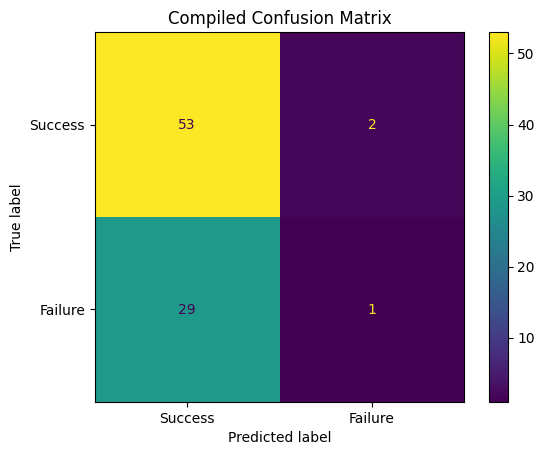

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## 3 Layers
2 hidden layers. No true positives predicted in validation

Training average accuracy: 65%

Validation average accuracy: 61%


Estimated overfitting: 4%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'sigmoid'))
  model.add(Dense(8, activation = 'sigmoid'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 0.6762 - accuracy: 0.6190
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.6190
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6190
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6190
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6190
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6511 - accuracy: 0.6190
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6190
Epoch 8/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6190
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6339 - accuracy: 0.6349
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
keras classifications:  [[0.392

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6821676587301587
Standard deviation of accuracy: 0.04339834869691746
Average training confusion matrix: 
 {'tn': 41.0, 'fp': 0.25}
 {'fn': 20.0, 'tp': 2.5}
Average training accuracy:  0.6823529411764706
Average training precision:  0.9090909090909091
Average training recall:  0.1111111111111111

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       165
           1       0.91      0.11      0.20        90

    accuracy                           0.68       255
   macro avg       0.79      0.55      0.50       255
weighted avg       0.76      0.68      0.59       255



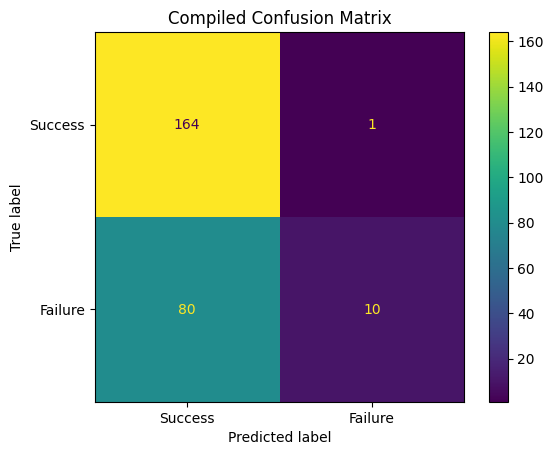

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

In [ ]:
instances_in_set(t_trues)

Number of true successes:  165
Number of true failures:  90


Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.6585497835497836
Standard deviation of accuracy: 0.19775528961273553
Average validation confusion matrix: 
 {'tn': 13.5, 'fp': 0.25}
 {'fn': 7.0, 'tp': 0.5}
Average validation accuracy:  0.6588235294117647
Average validation precision:  0.6666666666666666
Average validation recall:  0.06666666666666667

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.66      0.98      0.79        55
           1       0.67      0.07      0.12        30

    accuracy                           0.66        85
   macro avg       0.66      0.52      0.45        85
weighted avg       0.66      0.66      0.55        85



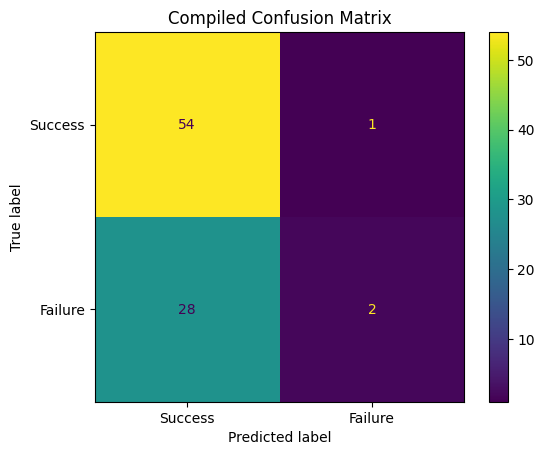

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

In [ ]:
instances_in_set(v_trues)

Number of true successes:  55
Number of true failures:  30


# <font color= 'purple'> Experiment 2: Activation Functions (sigmoid, ReLu, PReLU)
2 layers

Suspicion that sigmoid is mainly outputting 0, classification reports (containing a macro average) were used for better insight

Extremely high overfitting for all three activation functions

Best model = ReLU

## Activation = ReLU
1 hidden layer

Training average accuracy: 73% --- Macro: 69%

Validation average accuracy: 62% --- Macro: 47%

Estimated overfitting: 8%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 3ms/step - loss: 1.5770 - accuracy: 0.5238
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 1.0507 - accuracy: 0.5714
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 0.8895 - accuracy: 0.6349
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8634 - accuracy: 0.6508
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7413 - accuracy: 0.6667
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7190 - accuracy: 0.6984
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.7143
Epoch 8/10
63/63 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6825
Epoch 9/10
63/63 [==============================] - 0s 3ms/step - loss: 0.5926 - accuracy: 0.6508
Epoch 10/10
1/1 [==============================] - 0s 24ms/step
keras classifications:  [[0.333

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.7411954365079365
Standard deviation of accuracy: 0.056765437187635256
Average training confusion matrix: 
 {'tn': 31.25, 'fp': 10.0}
 {'fn': 6.5, 'tp': 16.0}
Average training accuracy:  0.7411764705882353
Average training precision:  0.6153846153846154
Average training recall:  0.7111111111111111

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       165
           1       0.62      0.71      0.66        90

    accuracy                           0.74       255
   macro avg       0.72      0.73      0.73       255
weighted avg       0.75      0.74      0.74       255



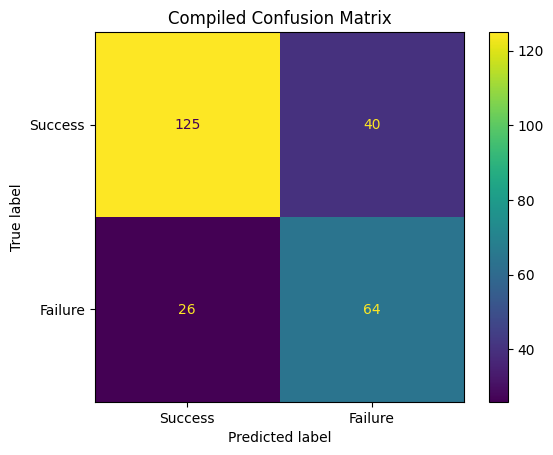

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.45995670995670995
Standard deviation of accuracy: 0.0757498449982559
Average validation confusion matrix: 
 {'tn': 7.25, 'fp': 6.5}
 {'fn': 5.0, 'tp': 2.5}
Average validation accuracy:  0.4588235294117647
Average validation precision:  0.2777777777777778
Average validation recall:  0.3333333333333333

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.59      0.53      0.56        55
           1       0.28      0.33      0.30        30

    accuracy                           0.46        85
   macro avg       0.43      0.43      0.43        85
weighted avg       0.48      0.46      0.47        85



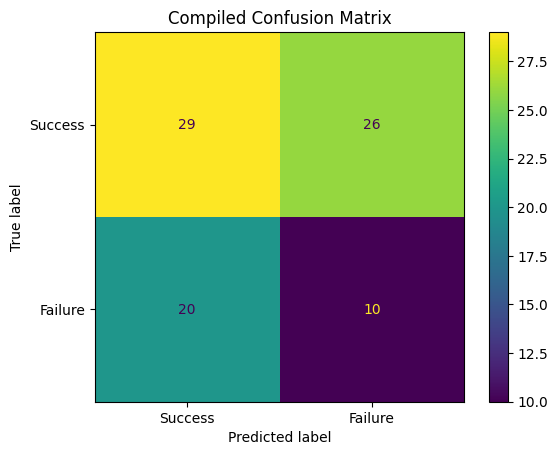

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Activation = Sigmoid
1 hidden layer

Training average accuracy: 70% -- Macro: 57%

Validation average accuracy: 60% -- Macro: 44%

Estimated overfitting: 8%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'sigmoid'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 0.7607 - accuracy: 0.6190
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7187 - accuracy: 0.6190
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6904 - accuracy: 0.6190
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6190
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6433 - accuracy: 0.6190
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.6190
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.6190
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6294 - accuracy: 0.6190
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6230 - accuracy: 0.6190
Epoch 10/10
1/1 [==============================] - 0s 22ms/step
keras classifications:  [[0.204

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.7172619047619048
Standard deviation of accuracy: 0.06379530411367111
Average training confusion matrix: 
 {'tn': 40.0, 'fp': 1.25}
 {'fn': 16.75, 'tp': 5.75}
Average training accuracy:  0.7176470588235294
Average training precision:  0.8214285714285714
Average training recall:  0.25555555555555554

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.70      0.97      0.82       165
           1       0.82      0.26      0.39        90

    accuracy                           0.72       255
   macro avg       0.76      0.61      0.60       255
weighted avg       0.75      0.72      0.67       255



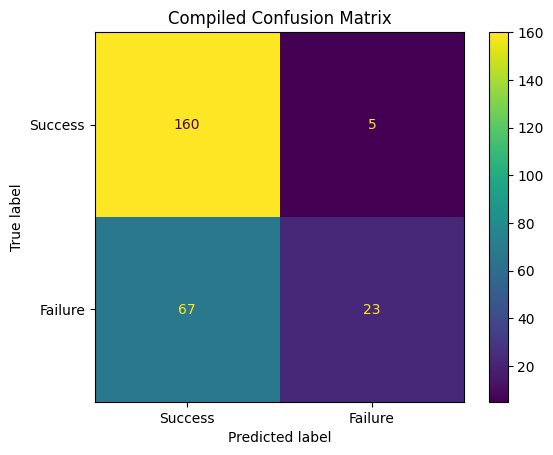

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.6222943722943722
Standard deviation of accuracy: 0.1951025868516054
Average validation confusion matrix: 
 {'tn': 12.5, 'fp': 1.25}
 {'fn': 6.75, 'tp': 0.75}
Average validation accuracy:  0.6235294117647059
Average validation precision:  0.375
Average validation recall:  0.1

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.65      0.91      0.76        55
           1       0.38      0.10      0.16        30

    accuracy                           0.62        85
   macro avg       0.51      0.50      0.46        85
weighted avg       0.55      0.62      0.55        85



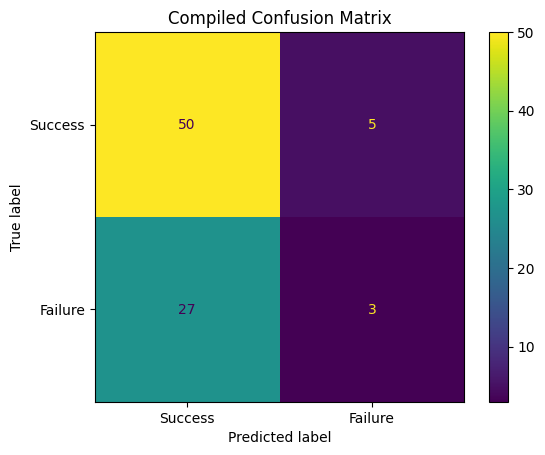

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Activation = PreLU
1 hidden layer

Training average accuracy: 73% -- Macro: 71%

Validation average accuracy: 41% -- Macro: 41%

Estimated overfitting: 30%

In [ ]:
from keras.layers import PReLU
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation=PReLU()))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 3.4199 - accuracy: 0.4603
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 2.0109 - accuracy: 0.5556
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 1.3563 - accuracy: 0.5873
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 1.0045 - accuracy: 0.6190
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9129 - accuracy: 0.5556
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7623 - accuracy: 0.5873
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7256 - accuracy: 0.6508
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7074 - accuracy: 0.6190
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.6565 - accuracy: 0.6190
Epoch 10/10
1/1 [==============================] - 0s 23ms/step
keras classifications:  [[0.838

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.7175719246031746
Standard deviation of accuracy: 0.10025339927440172
Average training confusion matrix: 
 {'tn': 34.5, 'fp': 6.75}
 {'fn': 11.25, 'tp': 11.25}
Average training accuracy:  0.7176470588235294
Average training precision:  0.625
Average training recall:  0.5

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       165
           1       0.62      0.50      0.56        90

    accuracy                           0.72       255
   macro avg       0.69      0.67      0.67       255
weighted avg       0.71      0.72      0.71       255



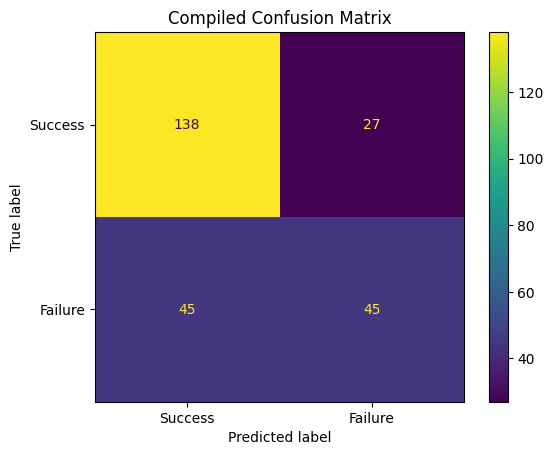

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.45941558441558444
Standard deviation of accuracy: 0.09370538361634262
Average validation confusion matrix: 
 {'tn': 7.75, 'fp': 6.0}
 {'fn': 5.5, 'tp': 2.0}
Average validation accuracy:  0.4588235294117647
Average validation precision:  0.25
Average validation recall:  0.26666666666666666

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        55
           1       0.25      0.27      0.26        30

    accuracy                           0.46        85
   macro avg       0.42      0.42      0.42        85
weighted avg       0.47      0.46      0.46        85



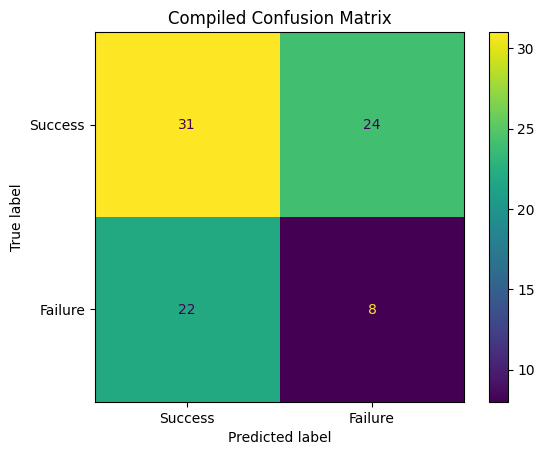

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> Experiment 3: Dropout Rate

2 layers, ReLU

Best model = 0.2

Helped reduced a lot of overfitting

## Dropout = 0.1
2 layers, ReLU

Training average accuracy: 67% --- Macro: 61%

Validation average accuracy: 60% --- Macro: 49%

Estimated overfitting: 10%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 2.6010 - accuracy: 0.4762
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 1.4110 - accuracy: 0.5556
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 1.6823 - accuracy: 0.5873
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 1.7261 - accuracy: 0.5397
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 1.1109 - accuracy: 0.6190
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 1.5738 - accuracy: 0.5397
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8960 - accuracy: 0.6825
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 1.1354 - accuracy: 0.5873
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9649 - accuracy: 0.5873
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
keras classifications:  [[1.440

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.7333209325396826
Standard deviation of accuracy: 0.03987790412161477
Average training confusion matrix: 
 {'tn': 34.0, 'fp': 7.25}
 {'fn': 9.75, 'tp': 12.75}
Average training accuracy:  0.7333333333333333
Average training precision:  0.6375
Average training recall:  0.5666666666666667

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       165
           1       0.64      0.57      0.60        90

    accuracy                           0.73       255
   macro avg       0.71      0.70      0.70       255
weighted avg       0.73      0.73      0.73       255



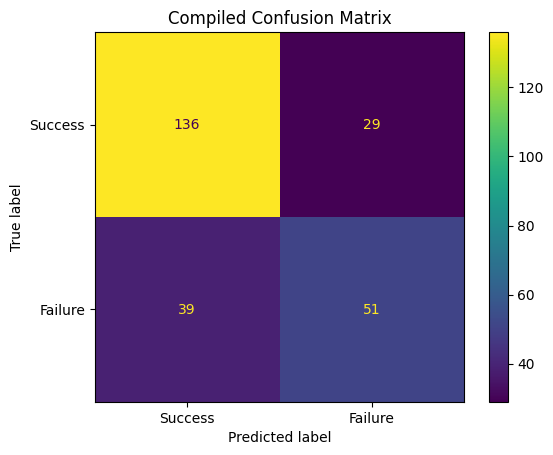

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.6347402597402597
Standard deviation of accuracy: 0.09314120920533997
Average validation confusion matrix: 
 {'tn': 10.0, 'fp': 3.75}
 {'fn': 4.0, 'tp': 3.5}
Average validation accuracy:  0.6352941176470588
Average validation precision:  0.4827586206896552
Average validation recall:  0.4666666666666667

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        55
           1       0.48      0.47      0.47        30

    accuracy                           0.64        85
   macro avg       0.60      0.60      0.60        85
weighted avg       0.63      0.64      0.63        85



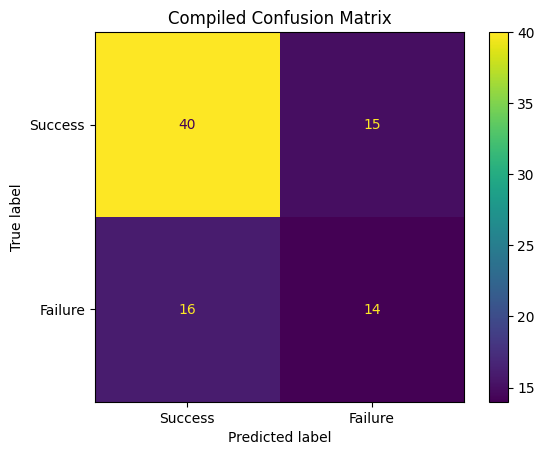

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Dropout = 0.2
2 layers, ReLU

Training average accuracy: 68% --- Macro: 64%

Validation average accuracy: 59% --- Macro: 52%

Estimated overfitting: 10%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 4.4427 - accuracy: 0.5873
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 1.8809 - accuracy: 0.5397
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 1.4270 - accuracy: 0.5238
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 1.4160 - accuracy: 0.6190
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9449 - accuracy: 0.7302
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8135 - accuracy: 0.5556
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8430 - accuracy: 0.6825
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8127 - accuracy: 0.5873
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7813 - accuracy: 0.6825
Epoch 10/10
1/1 [==============================] - 0s 21ms/step
keras classifications:  [[2.425

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.7332589285714286
Standard deviation of accuracy: 0.0933038384309235
Average training confusion matrix: 
 {'tn': 36.0, 'fp': 5.25}
 {'fn': 11.75, 'tp': 10.75}
Average training accuracy:  0.7333333333333333
Average training precision:  0.671875
Average training recall:  0.4777777777777778

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       165
           1       0.67      0.48      0.56        90

    accuracy                           0.73       255
   macro avg       0.71      0.68      0.68       255
weighted avg       0.72      0.73      0.72       255



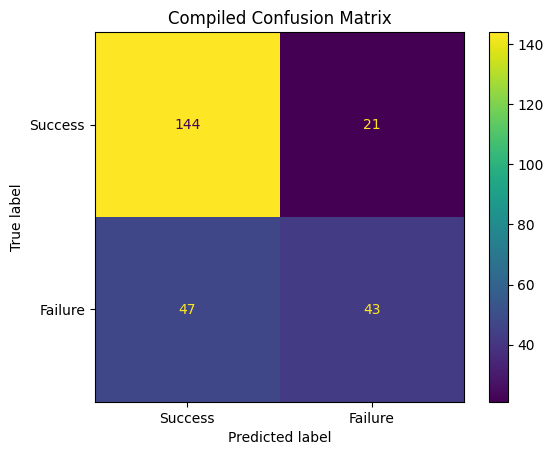

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.43452380952380953
Standard deviation of accuracy: 0.0927884361197613
Average validation confusion matrix: 
 {'tn': 7.75, 'fp': 6.0}
 {'fn': 6.0, 'tp': 1.5}
Average validation accuracy:  0.43529411764705883
Average validation precision:  0.2
Average validation recall:  0.2

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        55
           1       0.20      0.20      0.20        30

    accuracy                           0.44        85
   macro avg       0.38      0.38      0.38        85
weighted avg       0.44      0.44      0.44        85



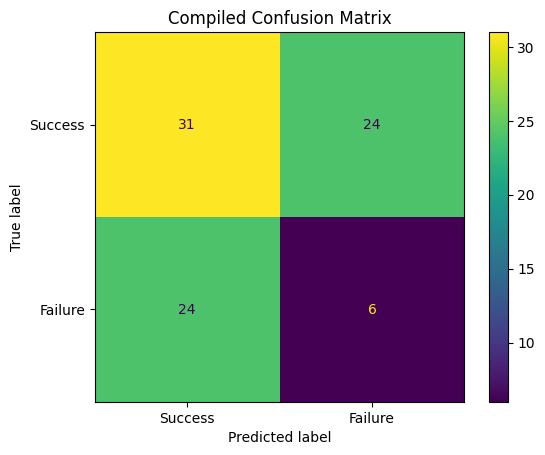

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Dropout = 0.3
2 layers, ReLU

Training average accuracy: 65% -- Macro: 58%

Validation average accuracy: 56% -- Macro: 47%

Estimated overfitting: 11%

In [ ]:
from keras.layers import PReLU
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 3ms/step - loss: 2.3517 - accuracy: 0.5238
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 2.1626 - accuracy: 0.4603
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 1.6775 - accuracy: 0.5397
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 1.1031 - accuracy: 0.6667
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 1.6222 - accuracy: 0.5556
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8868 - accuracy: 0.6984
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9973 - accuracy: 0.6667
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9574 - accuracy: 0.6508
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7373 - accuracy: 0.6984
Epoch 10/10
1/1 [==============================] - 0s 21ms/step
keras classifications:  [[3.761

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6902281746031746
Standard deviation of accuracy: 0.09055959224453378
Average training confusion matrix: 
 {'tn': 31.0, 'fp': 10.25}
 {'fn': 9.5, 'tp': 13.0}
Average training accuracy:  0.6901960784313725
Average training precision:  0.5591397849462365
Average training recall:  0.5777777777777777

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       165
           1       0.56      0.58      0.57        90

    accuracy                           0.69       255
   macro avg       0.66      0.66      0.66       255
weighted avg       0.69      0.69      0.69       255



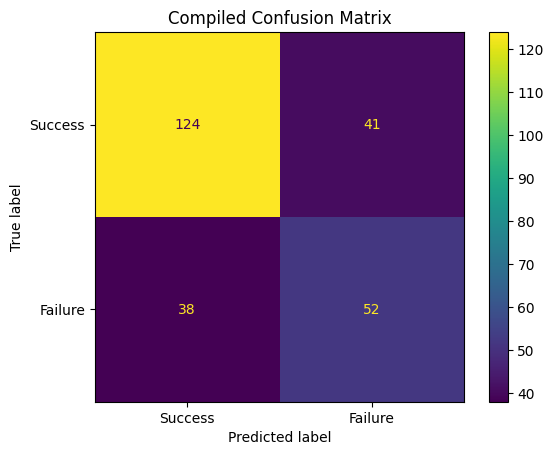

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.4832251082251082
Standard deviation of accuracy: 0.1163948334642601
Average validation confusion matrix: 
 {'tn': 8.5, 'fp': 5.25}
 {'fn': 5.75, 'tp': 1.75}
Average validation accuracy:  0.4823529411764706
Average validation precision:  0.25
Average validation recall:  0.23333333333333334

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        55
           1       0.25      0.23      0.24        30

    accuracy                           0.48        85
   macro avg       0.42      0.43      0.42        85
weighted avg       0.47      0.48      0.48        85



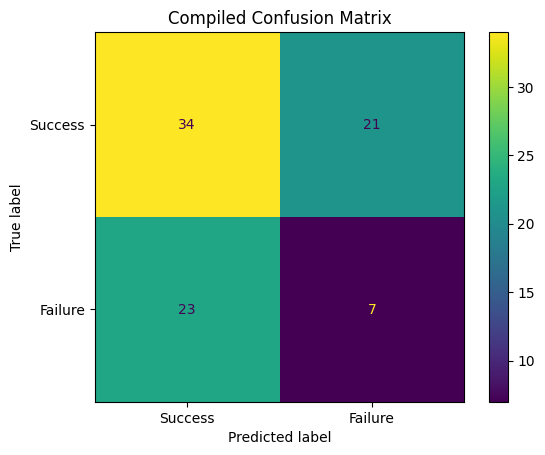

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Dropout = 0.4
2 layers, ReLU

Training average accuracy: 66% -- Macro: 56%

Validation average accuracy: 58% -- Macro: 48%

Estimated overfitting: 14%

In [ ]:
from keras.layers import PReLU
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 11.9996 - accuracy: 0.3333
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 6.5070 - accuracy: 0.3810
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 3.4017 - accuracy: 0.4444
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 1.6933 - accuracy: 0.4762
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 1.4218 - accuracy: 0.4762
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9525 - accuracy: 0.6667
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 1.0663 - accuracy: 0.6349
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8152 - accuracy: 0.6190
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 1.1790 - accuracy: 0.5556
Epoch 10/10
1/1 [==============================] - 0s 33ms/step
keras classifications:  [[0.41

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6432291666666666
Standard deviation of accuracy: 0.07479899279346391
Average training confusion matrix: 
 {'tn': 35.25, 'fp': 6.0}
 {'fn': 16.75, 'tp': 5.75}
Average training accuracy:  0.6431372549019608
Average training precision:  0.48936170212765956
Average training recall:  0.25555555555555554

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       165
           1       0.49      0.26      0.34        90

    accuracy                           0.64       255
   macro avg       0.58      0.56      0.55       255
weighted avg       0.61      0.64      0.61       255



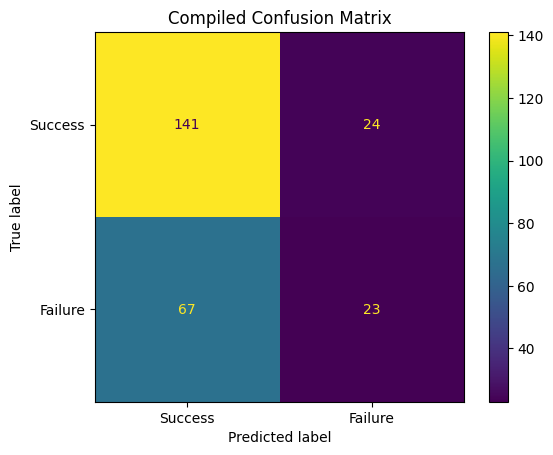

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.5400432900432901
Standard deviation of accuracy: 0.12168949750015527
Average validation confusion matrix: 
 {'tn': 11.0, 'fp': 2.75}
 {'fn': 7.0, 'tp': 0.5}
Average validation accuracy:  0.5411764705882353
Average validation precision:  0.15384615384615385
Average validation recall:  0.06666666666666667

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.61      0.80      0.69        55
           1       0.15      0.07      0.09        30

    accuracy                           0.54        85
   macro avg       0.38      0.43      0.39        85
weighted avg       0.45      0.54      0.48        85



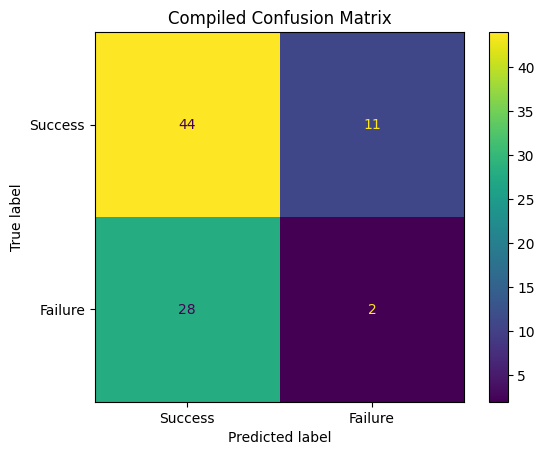

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> Experiment 4: Regularizer

2 layers, ReLU, 0.2

Best model = L1 = 0.3, L2 = 0.02
Helped reduce overfitting from estimated 10% down to estimated 3%


## L1 = 0.0, L2 = 0.0001
2 layers, ReLU

Training average accuracy: 67% --- Macro: 61%

Validation average accuracy: 52% --- Macro: 44%

Estimated overfitting: 15%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 2.1219 - accuracy: 0.6032
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 1.6831 - accuracy: 0.6032
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 1.6063 - accuracy: 0.6190
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.9898 - accuracy: 0.6825
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7770 - accuracy: 0.6349
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8833 - accuracy: 0.6667
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8429 - accuracy: 0.6667
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7380 - accuracy: 0.6667
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7473 - accuracy: 0.6984
Epoch 10/10
1/1 [==============================] - 0s 40ms/step
keras classifications:  [[0.153

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.7219742063492063
Standard deviation of accuracy: 0.09124776653553211
Average training confusion matrix: 
 {'tn': 34.25, 'fp': 7.0}
 {'fn': 10.75, 'tp': 11.75}
Average training accuracy:  0.7215686274509804
Average training precision:  0.6266666666666667
Average training recall:  0.5222222222222223

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       165
           1       0.63      0.52      0.57        90

    accuracy                           0.72       255
   macro avg       0.69      0.68      0.68       255
weighted avg       0.71      0.72      0.71       255



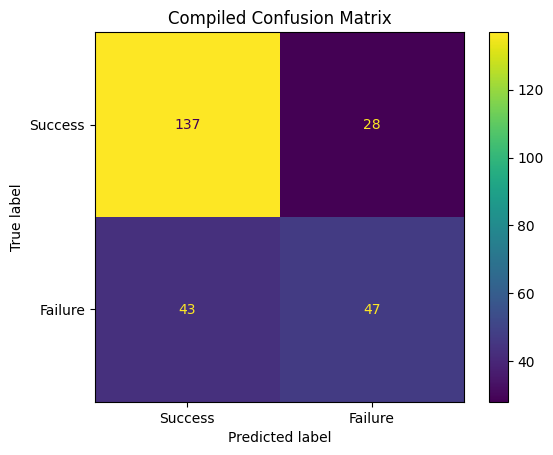

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.5178571428571429
Standard deviation of accuracy: 0.17847219464958275
Average validation confusion matrix: 
 {'tn': 9.5, 'fp': 4.25}
 {'fn': 6.0, 'tp': 1.5}
Average validation accuracy:  0.5176470588235295
Average validation precision:  0.2608695652173913
Average validation recall:  0.2

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        55
           1       0.26      0.20      0.23        30

    accuracy                           0.52        85
   macro avg       0.44      0.45      0.44        85
weighted avg       0.49      0.52      0.50        85



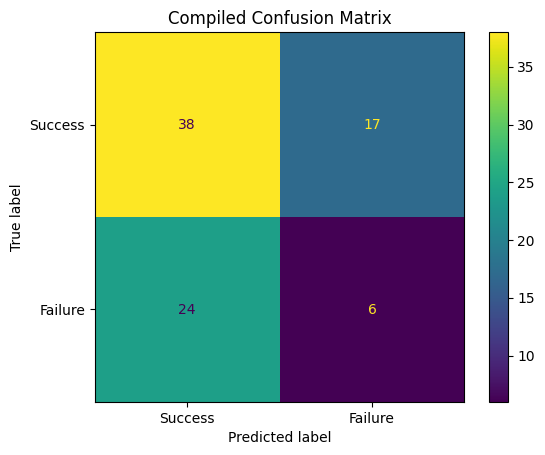

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## L1 = 0.0, L2 = 0.02
2 layers, ReLU

Training average accuracy: 66% --- Macro: 61%

Validation average accuracy: 53% --- Macro: 45%

Estimated overfitting: 14%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 18.3665 - accuracy: 0.3810
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 7.8456 - accuracy: 0.4603
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 6.0121 - accuracy: 0.4603
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 5.6791 - accuracy: 0.4286
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 3.5622 - accuracy: 0.5079
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 3.6940 - accuracy: 0.4286
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 3.1749 - accuracy: 0.4603
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 1.9993 - accuracy: 0.5873
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 2.0939 - accuracy: 0.6032
Epoch 10/10
1/1 [==============================] - 0s 40ms/step
keras classifications:  [[0.12

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6977926587301587
Standard deviation of accuracy: 0.07557884432367154
Average training confusion matrix: 
 {'tn': 34.75, 'fp': 6.5}
 {'fn': 12.75, 'tp': 9.75}
Average training accuracy:  0.6980392156862745
Average training precision:  0.6
Average training recall:  0.43333333333333335

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       165
           1       0.60      0.43      0.50        90

    accuracy                           0.70       255
   macro avg       0.67      0.64      0.64       255
weighted avg       0.69      0.70      0.68       255



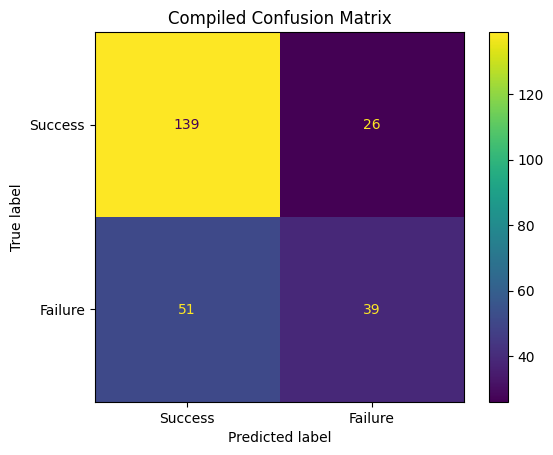

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.5887445887445888
Standard deviation of accuracy: 0.22558640520630124
Average validation confusion matrix: 
 {'tn': 10.75, 'fp': 3.0}
 {'fn': 5.75, 'tp': 1.75}
Average validation accuracy:  0.5882352941176471
Average validation precision:  0.3684210526315789
Average validation recall:  0.23333333333333334

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        55
           1       0.37      0.23      0.29        30

    accuracy                           0.59        85
   macro avg       0.51      0.51      0.50        85
weighted avg       0.55      0.59      0.56        85



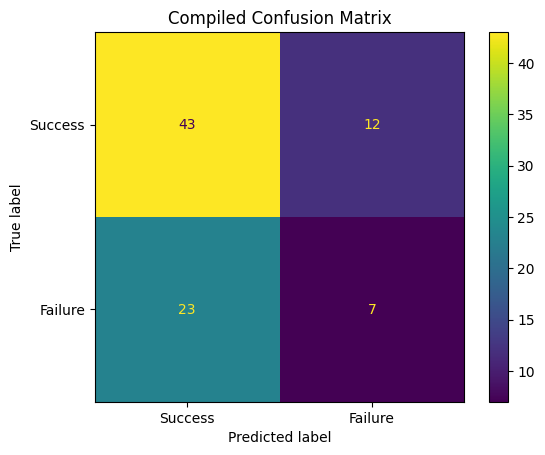

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## L1 = 0.1, L2 = 0.02
2 layers, ReLU

Training average accuracy: 69% --- Macro: 63%

Validation average accuracy: 48% --- Macro: 40%

Estimated overfitting: 14%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.1, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 11.2737 - accuracy: 0.4921
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 8.0987 - accuracy: 0.5873
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 6.4173 - accuracy: 0.5714
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 4.7767 - accuracy: 0.6032
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 3.5197 - accuracy: 0.6667
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 3.5258 - accuracy: 0.6032
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 2.6407 - accuracy: 0.6190
Epoch 8/10
63/63 [==============================] - 0s 3ms/step - loss: 2.5724 - accuracy: 0.5714
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 2.2382 - accuracy: 0.6032
Epoch 10/10
1/1 [==============================] - 0s 23ms/step
keras classifications:  [[5.16

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6625744047619048
Standard deviation of accuracy: 0.08231483920921619
Average training confusion matrix: 
 {'tn': 31.0, 'fp': 10.25}
 {'fn': 11.25, 'tp': 11.25}
Average training accuracy:  0.6627450980392157
Average training precision:  0.5232558139534884
Average training recall:  0.5

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       165
           1       0.52      0.50      0.51        90

    accuracy                           0.66       255
   macro avg       0.63      0.63      0.63       255
weighted avg       0.66      0.66      0.66       255



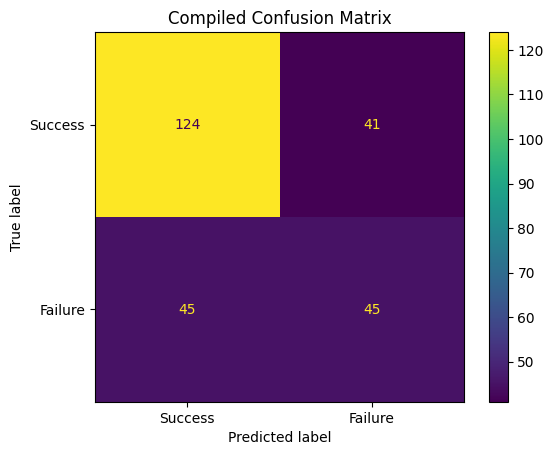

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.4485930735930736
Standard deviation of accuracy: 0.14018702854475576
Average validation confusion matrix: 
 {'tn': 8.0, 'fp': 5.75}
 {'fn': 6.0, 'tp': 1.5}
Average validation accuracy:  0.4470588235294118
Average validation precision:  0.20689655172413793
Average validation recall:  0.2

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.57      0.58      0.58        55
           1       0.21      0.20      0.20        30

    accuracy                           0.45        85
   macro avg       0.39      0.39      0.39        85
weighted avg       0.44      0.45      0.44        85



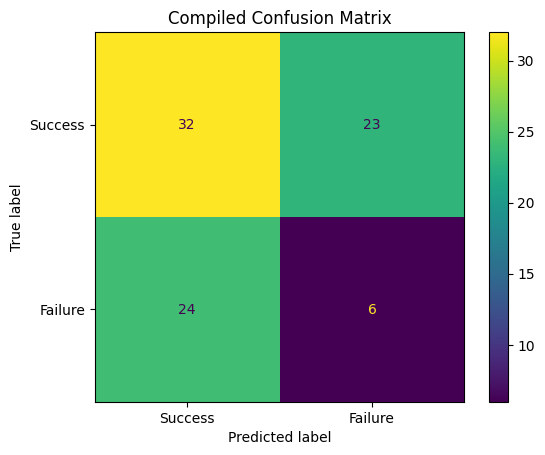

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## L1 = 0.2, L2 = 0.02
2 layers, ReLU

Training average accuracy: 65% --- Macro: 63%

Validation average accuracy: 45% --- Macro: 42%

Estimated overfitting: 14%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.2, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 19.3159 - accuracy: 0.5556
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 14.3589 - accuracy: 0.5873
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 10.8421 - accuracy: 0.5873
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 7.7918 - accuracy: 0.6190
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 5.9065 - accuracy: 0.5556
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 4.7433 - accuracy: 0.6032
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 4.2030 - accuracy: 0.6032
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 3.8087 - accuracy: 0.5397
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 3.2944 - accuracy: 0.6349
Epoch 10/10
1/1 [==============================] - 0s 33ms/step
keras classifications:  [[0.

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6744171626984127
Standard deviation of accuracy: 0.06428812909398444
Average training confusion matrix: 
 {'tn': 33.75, 'fp': 7.5}
 {'fn': 13.25, 'tp': 9.25}
Average training accuracy:  0.6745098039215687
Average training precision:  0.5522388059701493
Average training recall:  0.4111111111111111

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       165
           1       0.55      0.41      0.47        90

    accuracy                           0.67       255
   macro avg       0.64      0.61      0.62       255
weighted avg       0.66      0.67      0.66       255



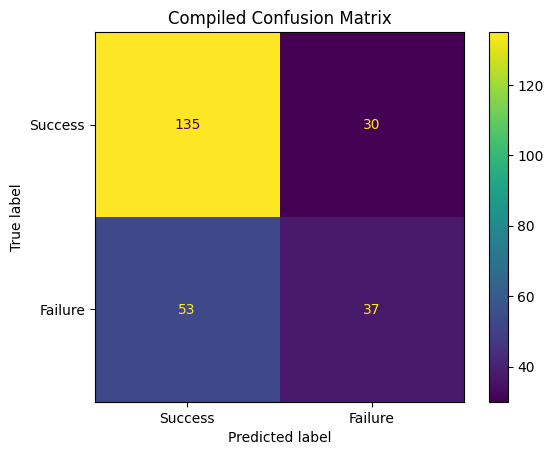

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.4826839826839827
Standard deviation of accuracy: 0.15636936511824254
Average validation confusion matrix: 
 {'tn': 9.0, 'fp': 4.75}
 {'fn': 6.25, 'tp': 1.25}
Average validation accuracy:  0.4823529411764706
Average validation precision:  0.20833333333333334
Average validation recall:  0.16666666666666666

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        55
           1       0.21      0.17      0.19        30

    accuracy                           0.48        85
   macro avg       0.40      0.41      0.40        85
weighted avg       0.46      0.48      0.47        85



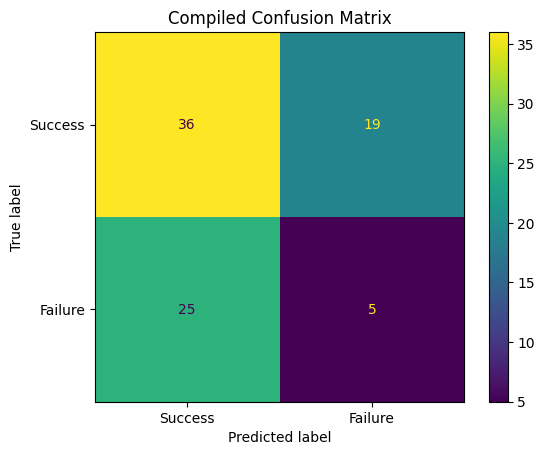

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## L1 = 0.3, L2 = 0.02
2 layers, ReLU

Training average accuracy: 61% --- Macro: 53%

Validation average accuracy: 64% --- Macro: 50%

Estimated overfitting: 3%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 28.9176 - accuracy: 0.4921
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 20.3587 - accuracy: 0.5873
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 14.5210 - accuracy: 0.5556
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 10.4887 - accuracy: 0.6032
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 7.0609 - accuracy: 0.6190
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 5.2886 - accuracy: 0.6190
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 5.0919 - accuracy: 0.5079
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 4.7156 - accuracy: 0.5079
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 4.3364 - accuracy: 0.6032
Epoch 10/10
1/1 [==============================] - 0s 23ms/step
keras classifications:  [[7

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6626984126984127
Standard deviation of accuracy: 0.08320978742213175
Average training confusion matrix: 
 {'tn': 30.5, 'fp': 10.75}
 {'fn': 10.75, 'tp': 11.75}
Average training accuracy:  0.6627450980392157
Average training precision:  0.5222222222222223
Average training recall:  0.5222222222222223

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       165
           1       0.52      0.52      0.52        90

    accuracy                           0.66       255
   macro avg       0.63      0.63      0.63       255
weighted avg       0.66      0.66      0.66       255



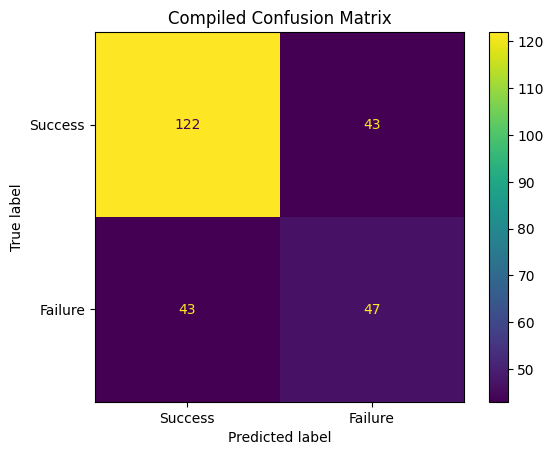

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.44696969696969696
Standard deviation of accuracy: 0.12755420621571942
Average validation confusion matrix: 
 {'tn': 8.25, 'fp': 5.5}
 {'fn': 6.25, 'tp': 1.25}
Average validation accuracy:  0.4470588235294118
Average validation precision:  0.18518518518518517
Average validation recall:  0.16666666666666666

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.57      0.60      0.58        55
           1       0.19      0.17      0.18        30

    accuracy                           0.45        85
   macro avg       0.38      0.38      0.38        85
weighted avg       0.43      0.45      0.44        85



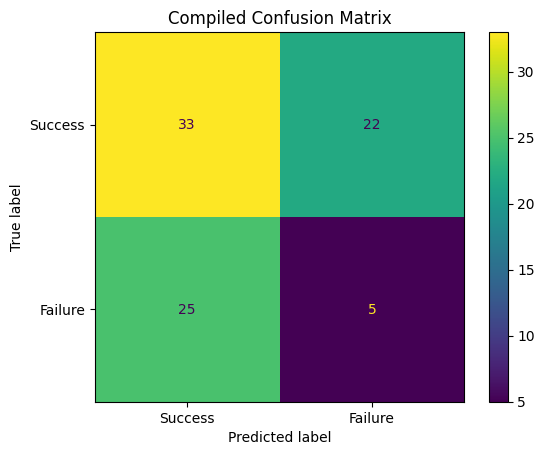

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> Experiment 5: Epochs

2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02

Best model = 10 Epochs

Even with higher number of epochs, overall accuracy is still very low. Maybe models need more training samples within each fold? Reduce number of folds for next experiment?


## Epochs = 20
2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02

Training average accuracy: 66% --- Macro: 62%

Validation average accuracy: 51% --- Macro: 45%

Estimated overfitting: 16%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 20
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/20
63/63 [==============================] - 1s 2ms/step - loss: 29.5245 - accuracy: 0.4127
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 21.8521 - accuracy: 0.5238
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 16.6619 - accuracy: 0.5714
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 12.4329 - accuracy: 0.5714
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 10.5593 - accuracy: 0.4921
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 8.6379 - accuracy: 0.5238
Epoch 7/20
63/63 [==============================] - 0s 2ms/step - loss: 7.5224 - accuracy: 0.5556
Epoch 8/20
63/63 [==============================] - 0s 2ms/step - loss: 6.7983 - accuracy: 0.5873
Epoch 9/20
63/63 [==============================] - 0s 2ms/step - loss: 5.7714 - accuracy: 0.5873
Epoch 10/20
63/63 [==============================] - 0s 2ms/step - loss: 6.0016 - accuracy

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6979786706349207
Standard deviation of accuracy: 0.03929755549396978
Average training confusion matrix: 
 {'tn': 36.5, 'fp': 4.75}
 {'fn': 14.5, 'tp': 8.0}
Average training accuracy:  0.6980392156862745
Average training precision:  0.6274509803921569
Average training recall:  0.35555555555555557

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       165
           1       0.63      0.36      0.45        90

    accuracy                           0.70       255
   macro avg       0.67      0.62      0.62       255
weighted avg       0.68      0.70      0.67       255



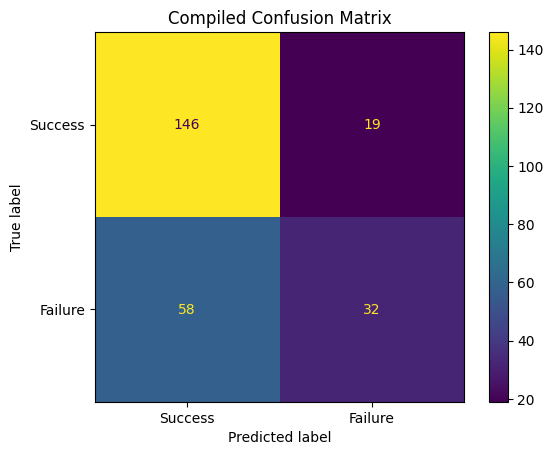

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.5643939393939394
Standard deviation of accuracy: 0.1369411172918577
Average validation confusion matrix: 
 {'tn': 10.0, 'fp': 3.75}
 {'fn': 5.5, 'tp': 2.0}
Average validation accuracy:  0.5647058823529412
Average validation precision:  0.34782608695652173
Average validation recall:  0.26666666666666666

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.65      0.73      0.68        55
           1       0.35      0.27      0.30        30

    accuracy                           0.56        85
   macro avg       0.50      0.50      0.49        85
weighted avg       0.54      0.56      0.55        85



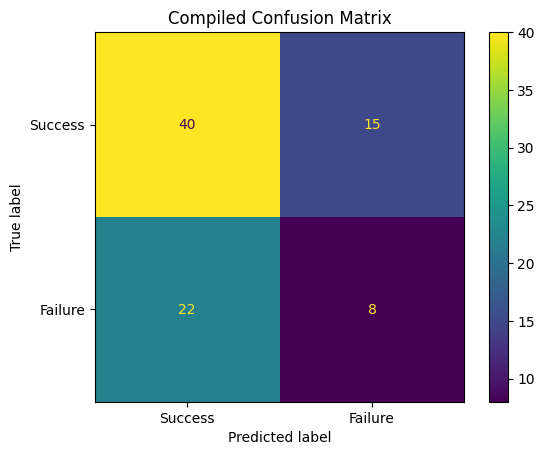

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Epochs = 15
2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02

Training average accuracy: 64% --- Macro: 58%

Validation average accuracy: 52% --- Macro: 45%

Estimated overfitting: 12%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 15
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/15
63/63 [==============================] - 1s 2ms/step - loss: 26.6517 - accuracy: 0.4921
Epoch 2/15
63/63 [==============================] - 0s 2ms/step - loss: 18.5205 - accuracy: 0.4921
Epoch 3/15
63/63 [==============================] - 0s 2ms/step - loss: 12.4737 - accuracy: 0.5397
Epoch 4/15
63/63 [==============================] - 0s 3ms/step - loss: 7.7615 - accuracy: 0.6032
Epoch 5/15
63/63 [==============================] - 0s 2ms/step - loss: 5.2901 - accuracy: 0.5079
Epoch 6/15
63/63 [==============================] - 0s 2ms/step - loss: 3.8331 - accuracy: 0.4444
Epoch 7/15
63/63 [==============================] - 0s 2ms/step - loss: 3.0513 - accuracy: 0.6349
Epoch 8/15
63/63 [==============================] - 0s 2ms/step - loss: 2.7233 - accuracy: 0.5873
Epoch 9/15
63/63 [==============================] - 0s 2ms/step - loss: 2.5906 - accuracy: 0.5873
Epoch 10/15
63/63 [==============================] - 0s 2ms/step - loss: 2.4121 - accuracy: 

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6742931547619048
Standard deviation of accuracy: 0.04644006160761926
Average training confusion matrix: 
 {'tn': 32.5, 'fp': 8.75}
 {'fn': 12.0, 'tp': 10.5}
Average training accuracy:  0.6745098039215687
Average training precision:  0.5454545454545454
Average training recall:  0.4666666666666667

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       165
           1       0.55      0.47      0.50        90

    accuracy                           0.67       255
   macro avg       0.64      0.63      0.63       255
weighted avg       0.67      0.67      0.67       255



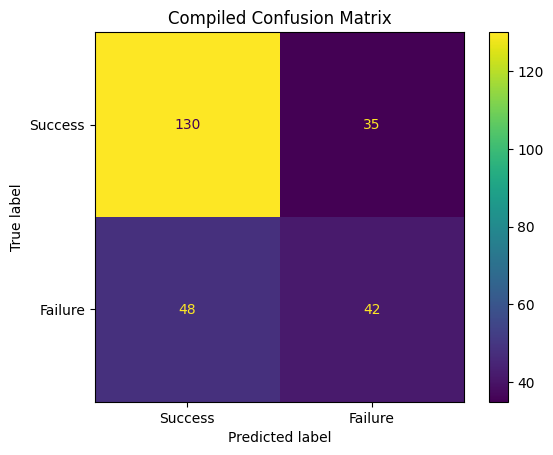

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.4599567099567099
Standard deviation of accuracy: 0.13908084409483049
Average validation confusion matrix: 
 {'tn': 7.5, 'fp': 6.25}
 {'fn': 5.25, 'tp': 2.25}
Average validation accuracy:  0.4588235294117647
Average validation precision:  0.2647058823529412
Average validation recall:  0.3

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.59      0.55      0.57        55
           1       0.26      0.30      0.28        30

    accuracy                           0.46        85
   macro avg       0.43      0.42      0.42        85
weighted avg       0.47      0.46      0.47        85



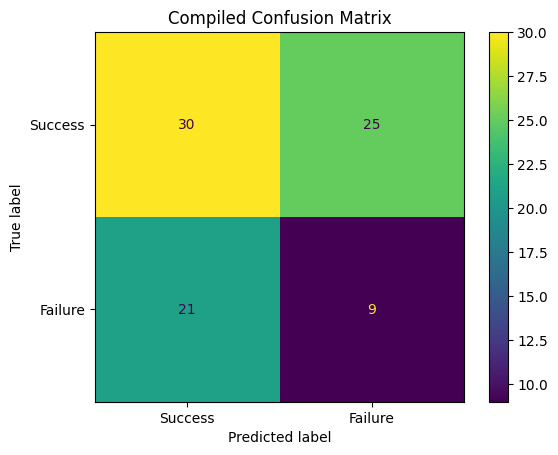

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## Epochs = 10
2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02

Training average accuracy: 64% --- Macro: 55%

Validation average accuracy: 58% --- Macro: 48%

Estimated overfitting: 7%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 27.8985 - accuracy: 0.5714
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 19.0798 - accuracy: 0.4921
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 12.4829 - accuracy: 0.5397
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 8.2196 - accuracy: 0.4762
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 5.2999 - accuracy: 0.4127
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 3.3384 - accuracy: 0.5556
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 3.1707 - accuracy: 0.5714
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 2.7863 - accuracy: 0.5556
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 2.4410 - accuracy: 0.6349
Epoch 10/10
1/1 [==============================] - 0s 24ms/step
keras classifications:  [[0.

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6194816468253969
Standard deviation of accuracy: 0.06735180873209945
Average training confusion matrix: 
 {'tn': 31.0, 'fp': 10.25}
 {'fn': 14.0, 'tp': 8.5}
Average training accuracy:  0.6196078431372549
Average training precision:  0.4533333333333333
Average training recall:  0.37777777777777777

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       165
           1       0.45      0.38      0.41        90

    accuracy                           0.62       255
   macro avg       0.57      0.56      0.57       255
weighted avg       0.61      0.62      0.61       255



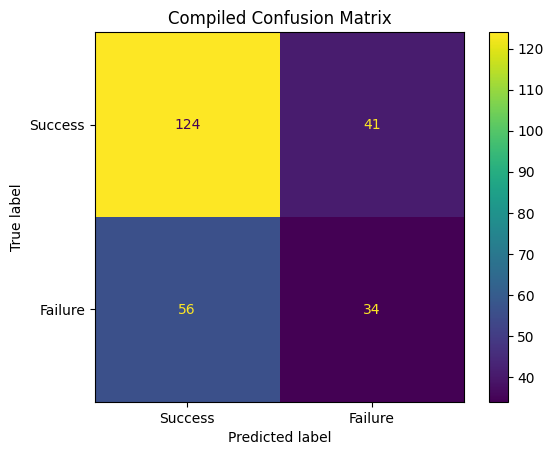

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.538961038961039
Standard deviation of accuracy: 0.18265371817999812
Average validation confusion matrix: 
 {'tn': 9.25, 'fp': 4.5}
 {'fn': 5.25, 'tp': 2.25}
Average validation accuracy:  0.5411764705882353
Average validation precision:  0.3333333333333333
Average validation recall:  0.3

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.64      0.67      0.65        55
           1       0.33      0.30      0.32        30

    accuracy                           0.54        85
   macro avg       0.49      0.49      0.49        85
weighted avg       0.53      0.54      0.54        85



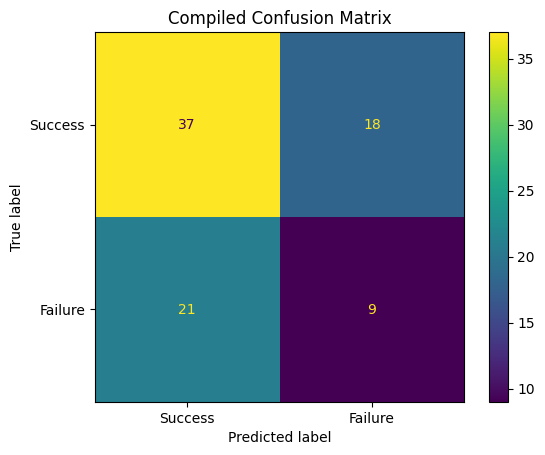

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> Experiment 6: K-folds

2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02, 10 Epochs

Best model = 3 K-Folds

## K-folds = 3
2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02, 10 epochs

Training average accuracy: 67% --- Macro: 62%

Validation average accuracy: 53% --- Macro: 47%

Estimated overfitting: 8%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 3

In [ ]:
model, t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
56/56 [==============================] - 1s 2ms/step - loss: 27.4239 - accuracy: 0.6250
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 20.6396 - accuracy: 0.5714
Epoch 3/10
56/56 [==============================] - 0s 2ms/step - loss: 15.1615 - accuracy: 0.5893
Epoch 4/10
56/56 [==============================] - 0s 2ms/step - loss: 11.1929 - accuracy: 0.5536
Epoch 5/10
56/56 [==============================] - 0s 2ms/step - loss: 8.2021 - accuracy: 0.6250
Epoch 6/10
56/56 [==============================] - 0s 2ms/step - loss: 5.4756 - accuracy: 0.6607
Epoch 7/10
56/56 [==============================] - 0s 2ms/step - loss: 4.2914 - accuracy: 0.6607
Epoch 8/10
56/56 [==============================] - 0s 2ms/step - loss: 4.2218 - accuracy: 0.6964
Epoch 9/10
56/56 [==============================] - 0s 2ms/step - loss: 4.4241 - accuracy: 0.6250
Epoch 10/10
1/1 [==============================] - 0s 35ms/step
keras classifications:  [[3

Training  Metrics from Cross Validation

Total Predictions:  170


Mean (exact) accuracy: 0.670530492898914
Standard deviation of accuracy: 0.03647773077549652
Average training confusion matrix: 
 {'tn': 29.0, 'fp': 7.666666666666667}
 {'fn': 11.0, 'tp': 9.0}
Average training accuracy:  0.6705882352941177
Average training precision:  0.5399999999999999
Average training recall:  0.45

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       110
           1       0.54      0.45      0.49        60

    accuracy                           0.67       170
   macro avg       0.63      0.62      0.62       170
weighted avg       0.66      0.67      0.66       170



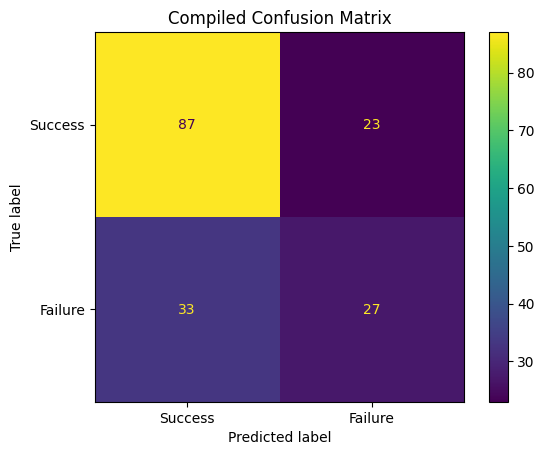

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.5287356321839081
Standard deviation of accuracy: 0.05001812921403721
Average validation confusion matrix: 
 {'tn': 12.333333333333334, 'fp': 6.0}
 {'fn': 7.333333333333333, 'tp': 2.6666666666666665}
Average validation accuracy:  0.5294117647058824
Average validation precision:  0.3076923076923077
Average validation recall:  0.26666666666666666

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        55
           1       0.31      0.27      0.29        30

    accuracy                           0.53        85
   macro avg       0.47      0.47      0.47        85
weighted avg       0.51      0.53      0.52        85



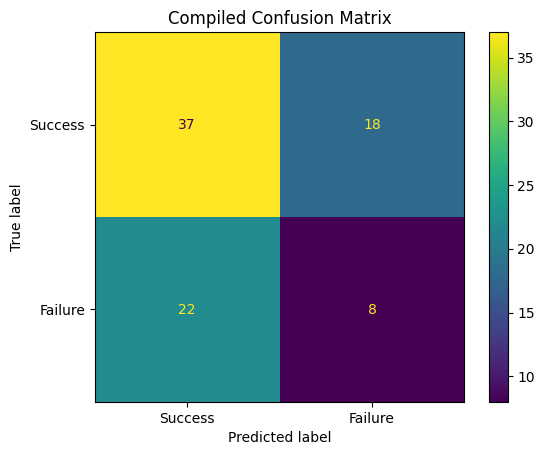

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## K-folds = 2
2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02, 10 epochs

Training average accuracy: 68% --- Macro: 64%

Validation average accuracy: 52% --- Macro: 41%

Estimated overfitting: 23%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 2

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
42/42 [==============================] - 1s 2ms/step - loss: 34.1583 - accuracy: 0.4524
Epoch 2/10
42/42 [==============================] - 0s 2ms/step - loss: 25.8000 - accuracy: 0.3810
Epoch 3/10
42/42 [==============================] - 0s 3ms/step - loss: 18.7925 - accuracy: 0.4048
Epoch 4/10
42/42 [==============================] - 0s 2ms/step - loss: 14.5640 - accuracy: 0.4762
Epoch 5/10
42/42 [==============================] - 0s 2ms/step - loss: 10.5231 - accuracy: 0.4286
Epoch 6/10
42/42 [==============================] - 0s 2ms/step - loss: 8.1025 - accuracy: 0.4048
Epoch 7/10
42/42 [==============================] - 0s 2ms/step - loss: 6.0567 - accuracy: 0.5238
Epoch 8/10
42/42 [==============================] - 0s 2ms/step - loss: 5.0914 - accuracy: 0.5476
Epoch 9/10
42/42 [==============================] - 0s 2ms/step - loss: 4.2450 - accuracy: 0.5238
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
keras classifications:  [[0

Training  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.6935215946843853
Standard deviation of accuracy: 0.050664451827242496
Average training confusion matrix: 
 {'tn': 20.0, 'fp': 7.5}
 {'fn': 5.5, 'tp': 9.5}
Average training accuracy:  0.6941176470588235
Average training precision:  0.5588235294117647
Average training recall:  0.6333333333333333

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        55
           1       0.56      0.63      0.59        30

    accuracy                           0.69        85
   macro avg       0.67      0.68      0.67        85
weighted avg       0.70      0.69      0.70        85



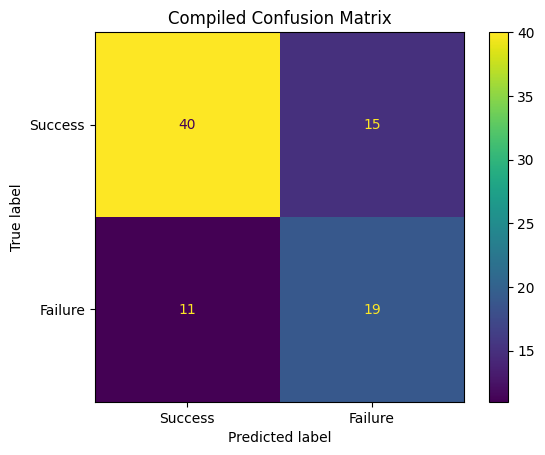

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.48283499446290146
Standard deviation of accuracy: 0.04097452934662238
Average validation confusion matrix: 
 {'tn': 16.0, 'fp': 11.5}
 {'fn': 10.5, 'tp': 4.5}
Average validation accuracy:  0.4823529411764706
Average validation precision:  0.28125
Average validation recall:  0.3

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.60      0.58      0.59        55
           1       0.28      0.30      0.29        30

    accuracy                           0.48        85
   macro avg       0.44      0.44      0.44        85
weighted avg       0.49      0.48      0.49        85



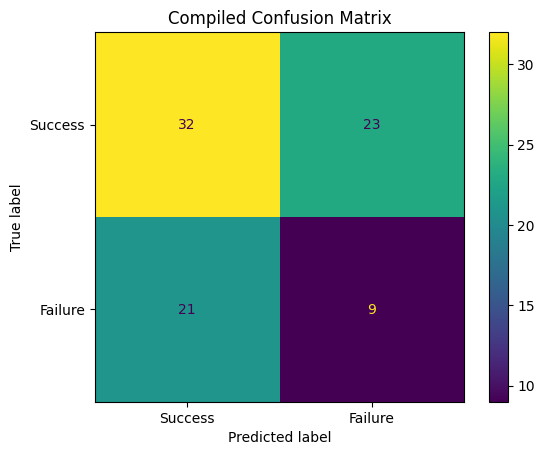

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

## K-Folds = 4
2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02, 10 epochs

Training average accuracy: 64% --- Macro: 55%

Validation average accuracy: 58% --- Macro: 48%

Estimated overfitting: 7%

In [ ]:
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = 'adam',
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 4

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 31.2744 - accuracy: 0.5079
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 20.8937 - accuracy: 0.5873
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 14.2534 - accuracy: 0.5556
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 9.9017 - accuracy: 0.5556
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 6.7820 - accuracy: 0.6667
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 5.5176 - accuracy: 0.5397
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 4.0727 - accuracy: 0.6349
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 4.1429 - accuracy: 0.5714
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 3.9340 - accuracy: 0.5873
Epoch 10/10
1/1 [==============================] - 0s 23ms/step
keras classifications:  [[5.

Training  Metrics from Cross Validation

Total Predictions:  255


Mean (exact) accuracy: 0.6236979166666666
Standard deviation of accuracy: 0.10128668477653335
Average training confusion matrix: 
 {'tn': 32.5, 'fp': 8.75}
 {'fn': 15.25, 'tp': 7.25}
Average training accuracy:  0.6235294117647059
Average training precision:  0.453125
Average training recall:  0.32222222222222224

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       165
           1       0.45      0.32      0.38        90

    accuracy                           0.62       255
   macro avg       0.57      0.56      0.55       255
weighted avg       0.60      0.62      0.61       255



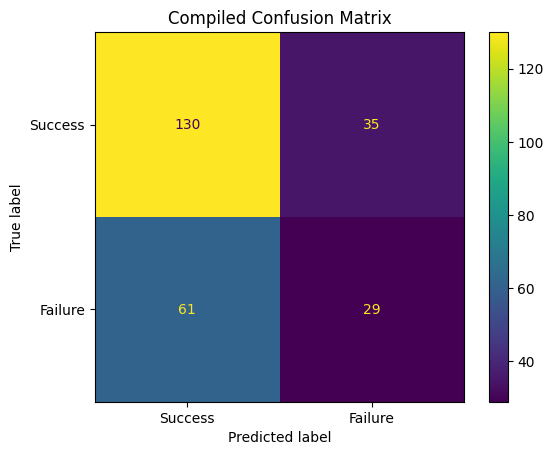

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.5270562770562771
Standard deviation of accuracy: 0.1547391985280481
Average validation confusion matrix: 
 {'tn': 9.75, 'fp': 4.0}
 {'fn': 6.0, 'tp': 1.5}
Average validation accuracy:  0.5294117647058824
Average validation precision:  0.2727272727272727
Average validation recall:  0.2

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        55
           1       0.27      0.20      0.23        30

    accuracy                           0.53        85
   macro avg       0.45      0.45      0.45        85
weighted avg       0.50      0.53      0.51        85



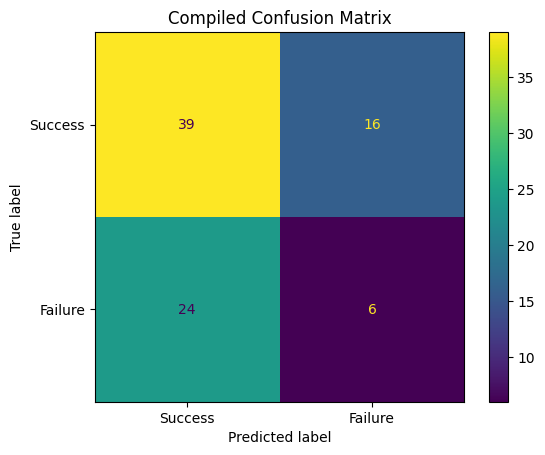

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> [Data] Experiment 7: Standardization

standardized data all numerical data (non binary)

Model performed very poorly and adhered to a certain value for predictions after standardization. Shows need for possibly balancing dataset?

### Data Standardization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# read csv
stat_X_df = pd.read_csv("view_full_features.csv")
stat_Y_df = pd.read_csv("full_targets.csv")

# removing weird indexes
stat_X_df = stat_X_df.drop('Unnamed: 0', axis=1)
stat_Y_df = stat_Y_df.drop('Unnamed: 0', axis=1)

# remove outliers for plt recovery
outlier_ids = stat_X_df[stat_X_df['pltrecovery'] == 1000000.0].index
print("PLT Recovery Outliers at: ", outlier_ids)
stat_X_df = stat_X_df.drop(outlier_ids, axis=0)
stat_Y_df = stat_Y_df.drop(outlier_ids, axis=0)

# standardize
scaler = MinMaxScaler()
cols_to_stat = ['donorage', 'recipientage', 'cd34kgx10d6', 'cd3dcd34', 'cd3dkgx10d8', 'rbodymass', 'ancrecovery', 'pltrecovery']
stat_X_df[cols_to_stat] = scaler.fit_transform(stat_X_df[cols_to_stat])

print("Data features shape: ", stat_X_df.shape); print("Data targets shape: ", stat_Y_df.shape)

# switch to float
stat_X_df = stat_X_df.astype('float64')
stat_Y_df = stat_Y_df.astype('float64')

# switch to numpy array
stat_X_arr = stat_X_df.to_numpy()
stat_Y_arr = stat_Y_df.to_numpy()


PLT Recovery Outliers at:  Index([46, 69, 122], dtype='int64')
Data features shape:  (139, 33)
Data targets shape:  (139, 1)


In [ ]:
stat_X_df

,recipientgender,stemcellsource,donorage,iiiv,gendermatch,donorabo,recipientabo,recipientrh,abomatch,cmvstatus,...,cd34kgx10d6,cd3dcd34,cd3dkgx10d8,rbodymass,ancrecovery,pltrecovery,AML,chronic,lymphoma,nonmalignant
0,1.0,1.0,0.123664,1.0,0.0,1.0,1.0,1.0,0.0,3.0,...,0.112476,0.010375,0.267267,0.410920,0.5625,0.149091,1.0,1.0,1.0,1.0
1,1.0,0.0,0.138808,1.0,0.0,-1.0,-1.0,1.0,0.0,0.0,...,0.065099,0.108504,0.018519,0.204023,0.3750,0.098182,1.0,1.0,1.0,1.0
2,1.0,0.0,0.229025,1.0,0.0,-1.0,-1.0,1.0,0.0,2.0,...,0.125461,0.188452,0.019019,0.244253,0.8125,0.036364,1.0,1.0,1.0,1.0
3,0.0,1.0,0.434888,0.0,0.0,1.0,2.0,0.0,1.0,0.0,...,0.895947,0.036908,0.651151,0.037356,0.2500,0.014545,0.0,1.0,0.0,0.0
4,1.0,1.0,0.413670,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,0.399193,0.034896,0.310310,0.202586,0.3125,0.014545,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1.0,0.0,0.336330,1.0,1.0,1.0,2.0,0.0,1.0,0.0,...,0.128444,0.161378,0.023023,0.310345,0.3750,0.327273,1.0,1.0,1.0,1.0
138,1.0,1.0,0.559524,1.0,0.0,1.0,1.0,0.0,0.0,3.0,...,0.180558,0.022304,0.217718,0.540230,0.3125,0.043636,0.0,0.0,1.0,0.0
139,0.0,1.0,0.125607,0.0,0.0,1.0,0.0,1.0,1.0,2.0,...,0.067556,0.007353,0.221722,0.547414,0.1250,0.072727,1.0,0.0,0.0,0.0
140,0.0,1.0,0.257208,1.0,0.0,1.0,-1.0,1.0,1.0,3.0,...,0.121776,0.013365,0.234735,0.382184,0.3750,0.021818,0.0,0.0,0.0,1.0


In [ ]:
# train test split with same random seed
# split the data into training and test sets (randomized)
s_trainX, s_testX, s_trainY, s_testY = train_test_split(stat_X_arr, stat_Y_arr, test_size = 0.35, random_state = 42)

print("trainInputs shape: ", s_trainX.shape); print("trainOutputs shape: ", s_trainY.shape)
print("testInputs shape: ", s_testX.shape); print("testInputs shape: ", s_testY.shape)

trainInputs shape:  (90, 33)
trainOutputs shape:  (90, 1)
testInputs shape:  (49, 33)
testInputs shape:  (49, 1)


### Running Model


2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02, 10 epochs, 3 K-folds

Training average accuracy: 62% --- Macro: 47%

Validation average accuracy: 68% --- Macro: 54%

Estimated overfitting: -5%

In [ ]:
from keras.optimizers import Adam

def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = Adam(learning_rate = 1e-05),
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 50
num_folds = 3

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = evaluate_model(s_trainX, s_trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Epoch 1/50
60/60 [==============================] - 2s 5ms/step - loss: 28.5858 - accuracy: 0.5833
Epoch 2/50
60/60 [==============================] - 0s 5ms/step - loss: 28.4805 - accuracy: 0.6333
Epoch 3/50
60/60 [==============================] - 0s 6ms/step - loss: 28.4113 - accuracy: 0.5833
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 28.3028 - accuracy: 0.6000
Epoch 5/50
60/60 [==============================] - 0s 5ms/step - loss: 28.1773 - accuracy: 0.5833
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 28.0917 - accuracy: 0.5833
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 28.0779 - accuracy: 0.5667
Epoch 8/50
60/60 [==============================] - 0s 5ms/step - loss: 27.9583 - accuracy: 0.6167
Epoch 9/50
60/60 [==============================] - 0s 5ms/step - loss: 27.8160 - accuracy: 0.6000
Epoch 10/50
60/60 [==============================] - 0s 5ms/step - loss: 27.7614 - acc

In [ ]:
t_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])

In [ ]:
t_trues

array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0.])

In [ ]:
v_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1.])

In [ ]:
v_trues

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0.])

Training  Metrics from Cross Validation

Total Predictions:  180


Mean (exact) accuracy: 0.6222222222222222
Standard deviation of accuracy: 0.047790695928014604
Average training confusion matrix: 
 {'tn': 34.666666666666664, 'fp': 6.0}
 {'fn': 16.666666666666668, 'tp': 2.6666666666666665}
Average training accuracy:  0.6222222222222221
Average training precision:  0.3076923076923077
Average training recall:  0.1379310344827586

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.68      0.85      0.75       122
           1       0.31      0.14      0.19        58

    accuracy                           0.62       180
   macro avg       0.49      0.50      0.47       180
weighted avg       0.56      0.62      0.57       180



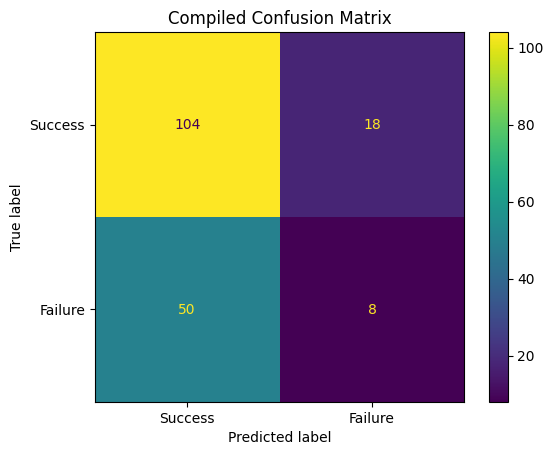

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  90


Mean (exact) accuracy: 0.6777777777777777
Standard deviation of accuracy: 0.10304020550550783
Average validation confusion matrix: 
 {'tn': 18.333333333333332, 'fp': 2.0}
 {'fn': 7.666666666666667, 'tp': 2.0}
Average validation accuracy:  0.6777777777777777
Average validation precision:  0.5
Average validation recall:  0.2068965517241379

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.71      0.90      0.79        61
           1       0.50      0.21      0.29        29

    accuracy                           0.68        90
   macro avg       0.60      0.55      0.54        90
weighted avg       0.64      0.68      0.63        90



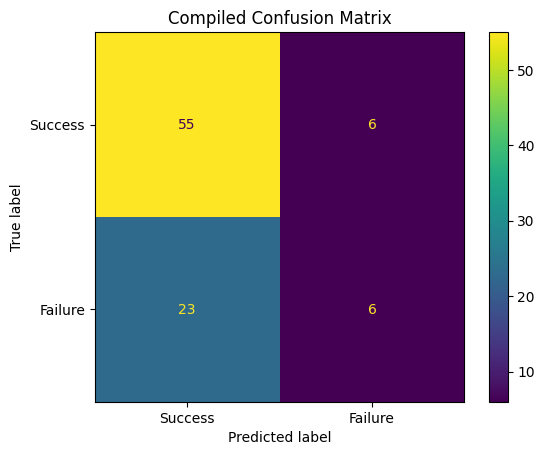

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'purple'> [Data] Experiment 8: Class Weighting
Model performed very poorly again, adhering to a certain value (class probability) in dataset. This helps verify that this dataset may be very difficult to learn, especially with the small number of samples to work with!

In [ ]:
print(f'Average class probability in training set:   {s_trainY.mean():.4f}')
#print(f'Average class probability in validation set: {valY.mean():.4f}')
print(f'Average class probability in test set:       {s_testY.mean():.4f}')

Average class probability in training set:   0.3222
Average class probability in test set:       0.3265


In [ ]:
counts = np.bincount(s_trainY[:, 0].astype(int))
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(s_trainY)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
class_weight = {0: weight_for_0, 1: weight_for_1}

Number of positive samples in training data: 29 (32.22% of total)


### Running Model


2 layers, ReLU, 0.2 Dropout, L1 = 0.3, L2 = 0.02, 10 epochs, 3 K-folds

Training average accuracy: 62% --- Macro: 60%

Validation average accuracy: 44% --- Macro: 41%

Estimated overfitting: 20%

In [ ]:
from keras.optimizers import Adam
def create_model():
  model = Sequential()
  model.add(keras.Input(shape=(33,)))
  model.add(Dense(16, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.3, l2 = 0.02)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = "binary_crossentropy",
                     optimizer = Adam(learning_rate = 1e-05),
                     metrics = ["accuracy"])

  return model

In [ ]:
u_batch_size = 1
max_epochs = 10
num_folds = 2

In [ ]:
t_preds, v_preds, t_trues, v_trues, t_acc_list, v_acc_list, t_cm_list, v_cm_list = balanced_evaluate_model(trainX, trainY, num_folds, u_batch_size, max_epochs)


Training for Fold # 1
Number of positive samples in training data: 19 (45.24% of total)
Epoch 1/10
42/42 [==============================] - 1s 5ms/step - loss: 28.7352 - accuracy: 0.4524
Epoch 2/10
42/42 [==============================] - 0s 6ms/step - loss: 28.6533 - accuracy: 0.5000
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 28.6071 - accuracy: 0.5714
Epoch 4/10
42/42 [==============================] - 0s 5ms/step - loss: 28.5200 - accuracy: 0.5714
Epoch 5/10
42/42 [==============================] - 0s 4ms/step - loss: 28.4639 - accuracy: 0.5952
Epoch 6/10
42/42 [==============================] - 0s 5ms/step - loss: 28.3795 - accuracy: 0.5952
Epoch 7/10
42/42 [==============================] - 0s 5ms/step - loss: 28.3040 - accuracy: 0.5476
Epoch 8/10
42/42 [==============================] - 0s 5ms/step - loss: 28.3040 - accuracy: 0.4762
Epoch 9/10
42/42 [==============================] - 0s 4ms/step - loss: 28.1805 - accuracy: 0.5238
Epoch 10/10
2/2 [===

In [ ]:
t_preds

array([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
t_trues

array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])

In [ ]:
v_preds

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
v_trues

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.])

Training  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.6223698781838316
Standard deviation of accuracy: 0.09856035437430782
Average training confusion matrix: 
 {'tn': 18.0, 'fp': 9.5}
 {'fn': 6.5, 'tp': 8.5}
Average training accuracy:  0.6235294117647059
Average training precision:  0.4722222222222222
Average training recall:  0.5666666666666667

Classification Report for Complied Training  Metrics
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        55
           1       0.47      0.57      0.52        30

    accuracy                           0.62        85
   macro avg       0.60      0.61      0.60        85
weighted avg       0.64      0.62      0.63        85



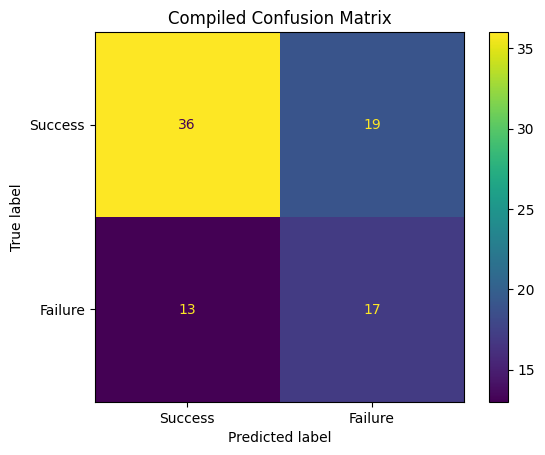

In [ ]:
print_metrics("Training", t_preds, t_trues, t_acc_list, t_cm_list)

Validation  Metrics from Cross Validation

Total Predictions:  85


Mean (exact) accuracy: 0.43660022148394245
Standard deviation of accuracy: 0.11101882613510522
Average validation confusion matrix: 
 {'tn': 13.5, 'fp': 14.0}
 {'fn': 10.0, 'tp': 5.0}
Average validation accuracy:  0.43529411764705883
Average validation precision:  0.2631578947368421
Average validation recall:  0.3333333333333333

Classification Report for Complied Validation  Metrics
              precision    recall  f1-score   support

           0       0.57      0.49      0.53        55
           1       0.26      0.33      0.29        30

    accuracy                           0.44        85
   macro avg       0.42      0.41      0.41        85
weighted avg       0.46      0.44      0.45        85



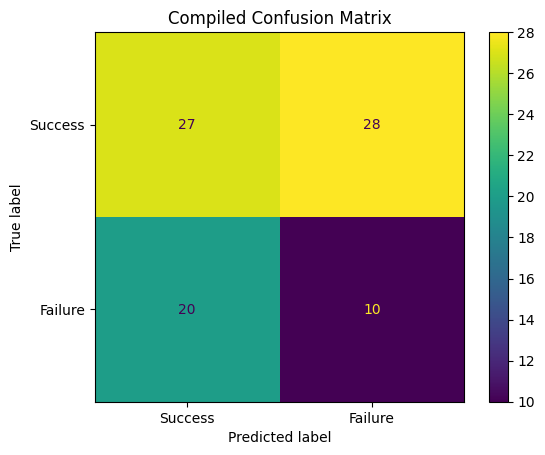

In [ ]:
print_metrics("Validation", v_preds, v_trues, v_acc_list, v_cm_list)

# <font color= 'blue'> Classifying Testing Data Split

In [ ]:
# Predict the labels of the training set samples
threshold = 0.5

t_predicted_labels = model.predict(testX)
for i in range(len(t_predicted_labels)):
  if (t_predicted_labels[i]>=threshold) == True:
    t_predicted_labels[i] = 1
  else:
    t_predicted_labels[i] = 0

acc_list = accuracy_score(testY, t_predicted_labels)

# do confusion matrix magic stuff
  # training
t_cm = confusion_matrix(testY, t_predicted_labels)

2/2 [==============================] - 0s 6ms/step


Test Metrics from Cross Validation

Total Predictions:  57


Accuracy: 0.6666666666666666
Testing accuracy:  0.6666666666666666
Testing precision:  0.4
Testing recall:  0.1111111111111111

Classification Report for Complied Testing Metrics
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        39
           1       0.40      0.11      0.17        18

    accuracy                           0.67        57
   macro avg       0.55      0.52      0.48        57
weighted avg       0.60      0.67      0.60        57



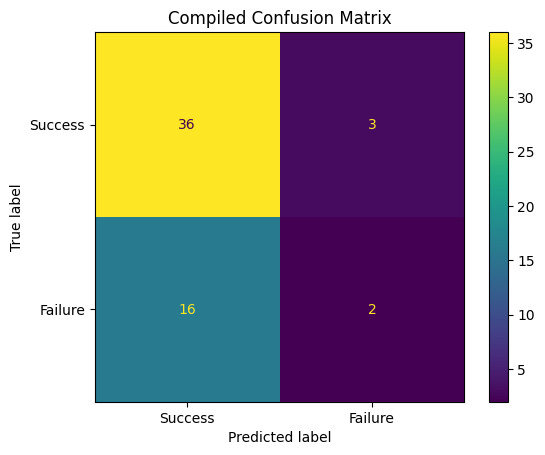

In [ ]:
preds = t_predicted_labels
trues = testY
mean_cm = t_cm

print("Test Metrics from Cross Validation")
print("")
print("Total Predictions: ", preds.shape[0])
print("")
plot_confusion_matrix(preds, trues)
print("")

print("Accuracy:", acc_list)


# REMEMBER CONFUSION MATRIX SYNTAX IS (TRUE VALUE, PREDICTED VALUE)
print("Testing accuracy: ", (mean_cm[0,0] + mean_cm[1,1])/(mean_cm[0,0] + mean_cm[1,1] + mean_cm[0,1] + mean_cm[1,0]))
print("Testing precision: ", (mean_cm[1,1])/(mean_cm[1,1] + mean_cm[0,1]))
print("Testing recall: ", (mean_cm[1,1])/(mean_cm[1,1] + mean_cm[1,0]))
print("")

print("Classification Report for Complied Testing Metrics")
print(classification_report(trues, preds, labels=[0, 1]))

# <font color= 'blue'> Evaluation of Models

*   precision = true positives / true positives + false positives
*   recall = true positives / true positives + false negatives

`the closer precision is to 1, the less false positives there are.`

`the closer recall is to 1, the less false negatives there are.`


Since *0 represents success* of bone marrow transplant (meaning patient survival status is alive), and *1 represents failure* of bone marrow transplant (meaning patient survival status is deceased) in the dataset,
*false positives are more costly (a lower precision score)*.
Therefore for this particular dataset, it is more important to have a high precision score for this data set.



*   Macro-average: "all classes equally contribute to the final averaged metric"
*   Weighted-average: "each classes's contribution to the average is weighted by its size"



Since the dataset is imbalanced, the macro average was used to evaluate models after experiment 1.

# <font color= 'blue'> Conclusion from Results
The final macro accuracy from the "best" model was around 60% on testing data, 50% on the validation data, and 48% on the testing data.

While this was the best model from the experiments, the benchmark accuracy on the initial cross training and validation was very similar, so no real improvement was made through experimentation.

Experiments for the ReLU, Dropout Rate, and Regularizer minimized the overfitting by around 10%, but accuracy was not improved. The overfitting estimate was also slightly arbitrary due to the variance in predictions and true labels caused by a low number of samples from cross validation, despite being averaged across multiple folds.

After data experiments 7 and 8 with the standardization of data and class weighting to mitigate for imbalance, the predictions adhered to values reflecting the class probability represented in the dataset. Even after reducing the initial learning rate for Adam and applying the model archiecture determined from previous experiments, accuracy was still very poor.

This suggests that this dataset was difficult to predict with a feed forward neural network model because there were not enough samples, with a lot of features.




# <font color= 'blue'> Future Improvements
Some future improvements could include possible using LOOCV instead of K-Fold cross validation to maximize the number of samples to train the model. Using K-Fold cross validation further decreased the already very low number of samples available. Some other improvements could also involve filling in missing values in the dataset with data augmentation to artifically increase the number of samples, since 45 samples had to be removed due to missing feature values.

# PROJECT GOAL 2: <font color= 'blue'> Entropy Calculations

While it was difficult to understand how to calculate of entropy with a ReLU activation function, entropy calculations for sigmoid activations for multiple layers of the network were possible. Additionally, the neural networks utilized sum of squares based loss.

Entropy calculations were done on a basic feed forward neural network for each layer. Neural networks with a differing number of epochs for the bone marrow transplant dataset. Cross validation was not utilized because this portion of the project was to help better understand the procress and behavior of entropy in a neural network, rather than trying to improve accuracy.

Although significant conclusions cannot be made, the results showed some interesting trends about entropy. Creating these calculations for the model helped show why only a sigmoid or softmax function can be used for the output of a neural network for cross entropy loss.

The results/trends are described next, and then the code and outputs are shown!

# <font color= 'blue'>  Trends/Results of Entropy Calculations

The entropy calculations for the bone marrow dataset neural network with 1 hidden layer and 1 output, the entropy per layer increased from 0.05 to 0.23.

For the neural network with 3 hidden layers, entropy per layer decreased first, and then increased again (0.006 --> 0.002 --> 0.05).

The results suggested a general trend of increase in entropy.

# <font color= 'blue'>  Entropy Code

## Preliminary Model Architecture
Model supports entropy calculation (log 2 --> in bits), activation functions (sigmoid), loss terms (sum of squares vs cross-entropy).
[First ran on XOR function to verify --> not displayed in notebook]

In [ ]:
# aesthetics & other imports
import numpy as np

class color:
  MAGENTA = '\033[35;48m'
  CYAN = '\033[36;48m'
  BOLD = '\033[37;48m'
  BLUE = '\033[34;48m'
  GREEN = '\033[32;48m'
  YELLOW = '\033[33;48m'
  RED = '\033[91;48m'
  BLACK = '\033[30;48m'
  BOLD = '\033[1;30;48m' # (bolded BLACK)
  UNDERLINE = '\033[4;37;48m'
  END = '\033[1;37;0m'


In [ ]:
# we will input a list of numbers of neurons to specify neurons in each layer (len(layers) = number of layers)
# e.g. layers = [3, 6, 3] -- 3 layers: 3 neurons, 6 neurons, 3 neurons

class FeedforwardNeuralNetwork:
  # specified activation for output layer

  def __init__(self, layers, alpha = 0.1, activation='sigmoid', output_activation='sigmoid', loss="sum-of-squares"):
    self.W = [] # list of matrices per layer
    self.layers = layers
    self.alpha = alpha
    self.activation = activation
    self.output_activation = output_activation
    self.loss = loss
    self.lossList = [] # list of loss per epoch
    self.epochEntropies = [] # list of total entropies per epoch (all layers normalized and additive) --> should it be normalized? probably not. doesnt need to be. just total entropy.
    self.layerEntropies = [] # list of lists of entropies per layer (goes by layer. 1st layer exempt) Note: ONLY FOR LAST EPOCH!!


    # initialize the weights between layers (up to the next-to-last one) as random
    for i in np.arange(0, len(layers) - 2): # np.arrange is the same thing as range
      currentNeurons = layers[i]
      nextNeurons = layers [i+1]
      self.W.append(np.random.randn(currentNeurons + 1, nextNeurons + 1)) # +1 is for the bias neurons # random.randn --> mean=0, standard deviation=1

    # initialize weights between the last two layers --> dont want bias for last layer!!
    self.W.append(np.random.randn(layers[-2] + 1, layers[-1]))

  def activate(self, layer, x): # layer starts with index 0 and includes input layer
  # SOFTMAX IS STRICTLY ONLY IN OUTPUT ACTIVATION LAYER

    if layer != (len(self.layers)-1):
      if self.activation == 'sigmoid':
        return 1.0 / (1 + np.exp(-x))
      if self.activation == 'reLU':
        return np.maximum(0, x)

    else: # means we are in the output layer
      if self.output_activation == 'sigmoid':
        return 1.0 / (1 + np.exp(-x))
      if self.output_activation == 'reLU':
        return np.maximum(0, x)

  def activation_Derivative(self, layer, z): # layer starts with index 0 and includes input layer
    # SOFTMAX IS STRICTLY ONLY IN OUTPUT ACTIVATION LAYER
    if layer != (len(self.layers)-1):
      if self.activation == 'sigmoid':
        return z * (1 - z)
      if self.activation == 'reLU':
        return np.heaviside(z, 1)
    else: # means we are in the output layer
      if self.output_activation == 'sigmoid':
        return z * (1 - z)
      if self.output_activation == 'reLU':
        return np.heaviside(z, 1)

  def compute_entropy(self, layer, activationList): # layer has to include input layer and start with index 0
    entropy = 0.0
    activate_type = ""

    if layer != (len(self.layers)-1): # if not last layer
      activate_type = self.activation
    else:
      activate_type = self.output_activation

    # if activate_type == 'reLU': --> entropy is 0, calculation not possible

    if activate_type == 'sigmoid':
      for i in range(len(activationList)): # want number of activations in activationList
        entropy += (activationList[i] * np.log2(activationList[i])) # sum of (activations * log of activations). log2 for bits
        entropy = -entropy # negative sign

    return entropy


  # fit the model
  def fit(self, X, y, epochs = 10000, update = 1000):
    # add a column of ones to the end of X
    X = np.hstack((X, np.ones([X.shape[0],1]))) # --> also automatically turns X into an array & ignores columns

    # list of lists per layer
    epoch_totalList = []

    for epoch in np.arange(0, epochs):
      master_entropyList = [[] for i in range(len(self.layers)-1)] # entropyList for each layer to equal list of entropies for each epoch. -1 because first layer does not have calculated entropy since it is an input layer
      # feed forward, backprop, and weight update
      for (x, target) in zip(X, y):

        # make a list of output activations from the first layer
        A = [np.atleast_2d(x)] # currently --> (just the original x values)

        # feed forward
        for layer in np.arange(0, len(self.W)): # for each layer in weights list, which does not include the first nodes because those are just the inputs. those nodes are not really neurons, they only calculate inputs*weights, and then the activation that occurs will be applied by the second layer's neurons
          neuronsNum = self.layers[layer+1]

          # feed through one layer and apply sigmoid activation
          z = A[layer].dot(self.W[layer]) # multiplying layer inputs with weights # .dot is the same as @ --> matrix multiplication
          out = self.activate(layer+1, z) # activation function being applied

          # add our network output to the list of activations --> append activation to A

          A.append(out) # storing activation
          insideOut = out[len(out)-1] # since out is a list of lists.
          entropy_perLay_perInp = self.compute_entropy(layer+1, insideOut) # entropy per layer per input --> no normalization
          master_entropyList[layer].append(entropy_perLay_perInp)
          # calculating entropy for the layer

        # backpropagation

        error = A[-1] - target # sum of least squares error, where A[-1] is the activation from the last layer (output)
        # only get error from last layer because it corresponds to the output/prediction, which can only be obtained from last layer?? (i think)


        # term proportional to the gradient --> make a list to store the derivatives
        last_lay_index = len(self.layers)-1
        D = [error * self.activation_Derivative(last_lay_index, A[-1])] # can change this to use cross-entropy error instead of sum of squared errors

        # cross-entropy only works for classification

        # loop backwards over the layers to build up deltas --> backpropagate for errors
        for layer in np.arange(len(A) - 2, 0, -1): # basicaly excludes input and output layer
          delta = D[-1].dot(self.W[layer].T)
          delta = delta * self.activation_Derivative(layer+1, A[layer])
          D.append(delta)

        # reverse the deltas since we looped in reverse
        D = D[::-1] # now D contains all of the partial derivatives

        # weight update
        for layer in np.arange(0, len(self.W)):
          self.W[layer] -= self.alpha * A[layer].T.dot(D[layer])

      totalEpochEnt = 0
      for i in range(len(master_entropyList)): # accessing master list --> i is layer #. layer starts at the second layer, since first layer is input layer (no calculation for input layer)
        summationEnt = 0

        for j in range(len(master_entropyList[i])): # j is input # for ith layer. trying to compile all input entropies and average them for each layer (layer goes by i)

          entropy_perLayList = master_entropyList[i]
          summationEnt += entropy_perLayList[j]

          if j == (len(entropy_perLayList)-1):

            summationAvg = summationEnt / len(entropy_perLayList) # len(entropy_perLayList = number of x's (input rows) in X)
            totalEpochEnt += summationAvg
            master_entropyList[i] = summationAvg/(self.layers[i+1]) # dividing total entropy for particular layer by its number of neurons

      if epoch == epochs-1:
        self.layerEntropies = master_entropyList # storing last and final epoch's individual layer entropies
        print("Note: The following entropies stated are the averages found only in the last epoch, which is epoch ", epoch)
        print("If the entropy is 0, then most likely the entropy is not able to be calculated for the specific activation function used in the layer")
        for i in range(len(master_entropyList)):
          print(color.MAGENTA, "Average total entropy for layer (Normalized)", i+2, ": ", master_entropyList[i], color.END, "Info: Layer had ", self.layers[i+1], " neurons. ")

      self.epochEntropies.append(totalEpochEnt) # storing total entropy from all layers from epoch (average across inputs)

      # print a status update
      if (epoch + 1) % update == 0:
        loss = self.computeLoss(X,y)
        self.lossList.append(loss)
        print(color.BLUE, 'EPOCH =', epoch + 1, 'LOSS = ', loss, color.END)

  def predict(self, X, addOnes = True):
    # initialize data, be sure it's the right dimension
    p = np.atleast_2d(X)

    # add a column of 1s for bias
    if addOnes: # in case we already did appending before we called the predict function!
      p = np.hstack((p, np.ones([X.shape[0],1])))

    # feed forward!
    for layer in np.arange(0, len(self.W)):
      p = self.activate(layer+1, np.dot(p, self.W[layer])) # only need final output, dont need to store all of it
      # final p will be the final predictions that were outputted from the last layer of the neural network

    # return the predictions
    return p

  def computeLoss(self, X, y):
    # initialize data, be sure it's the right dimension
    y = np.atleast_2d(y) # might not need this

    # feed the datapoints through the network to get predicted outputs
    predictions = self.predict(X, addOnes = False)

    # compute the sum of squared errors loss function
    if(self.loss == "sum-of-squares"):
      loss = np.sum((predictions - y)**2) / 2.0

    # compute cross entropy loss function. it is more effective because it uses a log so it more heavily penalizes bad predictions
    if(self.loss == "cross-entropy"):
      loss = np.sum(np.nan_to_num(-y * np.log(predictions) - (1 - y) * np.log(1 - predictions)))

    return loss


## Predicting Bone Marrow Transplant Dataset

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# split the data into training and test sets (randomized)
trainX, testX, trainY, testY = train_test_split(X_array, Y_array, test_size = 0.25, random_state = 1)

trainX = scale(trainX)
testX = scale(testX) # have to scale to make sure parameters are scaled the same in both --> question: how is it being scaled?

print("trainInputs shape: ", trainX.shape); print("trainOutputs shape: ", trainY.shape)
print("testInputs shape: ", testX.shape); print("testInputs shape: ", testY.shape)


trainInputs shape:  (106, 36)
trainOutputs shape:  (106, 1)
testInputs shape:  (36, 36)
testInputs shape:  (36, 1)


In [ ]:
print("for basic network: ")
# LOSS --> SUM OF SQUARES
# SIGMOID ACTIVATIONS AND SIGMOID OUTPUT ACTIVATIONS
model = FeedforwardNeuralNetwork(layers = [36, 1, 1]) # 3 layers, have to have 37 input "nodes" in first layer, and 1 output "nodes" in last layer
model.fit(trainX, trainY, 1000, 100) # making sure there are no overflow errors
print("")

print(testX)
predictions = model.predict(testX)
print("non interpreted version: ")
print(predictions)
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0
  else:
    predictions[i] = 1
print("interpreted version: ")
print(predictions)

#print(predictions)
print()
print("the true values are: ")
print(testY)
print("Seeing if predictions worked: ")
for i in range(len(predictions)):
  if predictions[i] == testY[i]:
    print("True")
  else:
    print("False, answer was: ", testY[i])




for basic network: 
 EPOCH = 100 LOSS =  9.359234811338407 
 EPOCH = 200 LOSS =  6.975886518954928 
 EPOCH = 300 LOSS =  6.484089065867445 
 EPOCH = 400 LOSS =  6.371906276104341 
 EPOCH = 500 LOSS =  6.317212572130562 
 EPOCH = 600 LOSS =  6.27219729500222 
 EPOCH = 700 LOSS =  6.222197801234125 
 EPOCH = 800 LOSS =  5.5238863040123665 
 EPOCH = 900 LOSS =  5.418052579250774 
Note: The following entropies stated are the averages found only in the last epoch, which is epoch  999
If the entropy is 0, then most likely the entropy is not able to be calculated for the specific activation function used in the layer
 Average total entropy for layer (Normalized) 2 :  0.053361545948121175  Info: Layer had  1  neurons. 
 Average total entropy for layer (Normalized) 3 :  0.23511621395485127  Info: Layer had  1  neurons. 
 EPOCH = 1000 LOSS =  5.212303083779949 

[[ 0.75180941  0.35355339  0.81377978 ... -1.18321596 -0.75180941
   0.79772404]
 [ 0.75180941  0.35355339 -1.561873   ... -1.18321596 

In [ ]:
print("for 4 layers basic neural network: ")
print("all sigmoid activations and sum of squares loss")
# LOSS --> SUM OF SQUARES
# SIGMOID ACTIVATIONS AND SIGMOID OUTPUT ACTIVATIONS
model = FeedforwardNeuralNetwork(layers = [36, 18, 9,  1]) # 3 layers, have to have 37 input "nodes" in first layer, and 1 output "nodes" in last layer
model.fit(trainX, trainY, 500, 100) # making sure there are no overflow errors
print("")

# print(testX)
predictions = model.predict(testX)
print("non interpreted version: ")
print(predictions)
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0
  else:
    predictions[i] = 1

#print(predictions)
print()
#print("the true values are: ")
print(testY)
print("Seeing if predictions worked: ")
for i in range(len(predictions)):
  if predictions[i] == testY[i]:
    print("True")
  else:
    print("False, answer was: ", testY[i])

for 4 layers basic neural network: 
 EPOCH = 100 LOSS =  0.2116806674020649 
 EPOCH = 200 LOSS =  0.0626595321399891 
 EPOCH = 300 LOSS =  0.03436943769347317 
 EPOCH = 400 LOSS =  0.023131917230458453 
Note: The following entropies stated are the averages found only in the last epoch, which is epoch  499
If the entropy is 0, then most likely the entropy is not able to be calculated for the specific activation function used in the layer
 Average total entropy for layer (Normalized) 2 :  0.006795591680520307  Info: Layer had  18  neurons. 
 Average total entropy for layer (Normalized) 3 :  -0.002644607537765477  Info: Layer had  9  neurons. 
 Average total entropy for layer (Normalized) 4 :  0.05856906477004634  Info: Layer had  1  neurons. 
 EPOCH = 500 LOSS =  0.017235085729944196 

[[ 0.75180941  0.35355339  0.81377978 ... -1.18321596 -0.75180941
   0.79772404]
 [ 0.75180941  0.35355339 -1.561873   ... -1.18321596 -0.75180941
  -1.25356634]
 [ 0.75180941  0.35355339  0.12207873 ...  

# <font color= 'blue'>